### BRESET Image Quality Anlaysis

### Setup Env

In [1]:
# To read and manipulate the data:
import pandas as pd
# To interact with the Operative System
import os
# Matrix operations
import numpy as np

# For missing values:
import missingno as msno

# For visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Train-Test Split:
from sklearn.model_selection import train_test_split

# To normalize the dataser
from sklearn.preprocessing import StandardScaler

# To balance the dataset during training
from sklearn.utils.class_weight import compute_class_weight

# Models:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# Visualize tree:
from sklearn.tree import plot_tree

# Metrics:
from sklearn.metrics import accuracy_score, classification_report


import warnings
warnings.filterwarnings("ignore")

In [2]:
# Path to the dataset:
DATASET = '/home/datascience/Retina/datasets/BRSET/labels.csv'

### Read the Dataset

In [3]:
# Read the labels:
df = pd.read_csv(DATASET)
df.head()

,image_id,patient_id,camera,patient_age,comorbidities,diabetes_time_y,insuline,patient_sex,exam_eye,diabetes,...,amd,vascular_occlusion,hypertensive_retinopathy,drusens,hemorrhage,retinal_detachment,myopic_fundus,increased_cup_disc,other,quality
0,img00001,1,Canon CR,48.0,diabetes1,12,yes,1,1,yes,...,0,0,0,0,0,0,0,1,0,Adequate
1,img00002,1,Canon CR,48.0,diabetes1,12,yes,1,2,yes,...,0,0,0,0,0,0,0,1,0,Adequate
2,img00003,2,Canon CR,18.0,diabetes1,7,yes,2,1,yes,...,0,0,0,0,0,0,0,0,0,Adequate
3,img00004,2,Canon CR,18.0,diabetes1,7,yes,2,2,yes,...,0,0,0,0,0,0,0,0,0,Adequate
4,img00005,3,Canon CR,22.0,diabetes1,11,yes,1,1,yes,...,0,0,0,0,0,0,0,0,0,Adequate


In [4]:
# See the columns:
df.columns

Index(['image_id', 'patient_id', 'camera', 'patient_age', 'comorbidities',
       'diabetes_time_y', 'insuline', 'patient_sex', 'exam_eye', 'diabetes',
       'nationality', 'optic_disc', 'vessels', 'macula', 'DR_SDRG', 'DR_ICDR',
       'focus', 'iluminaton', 'image_field', 'artifacts',
       'diabetic_retinopathy', 'macular_edema', 'scar', 'nevus', 'amd',
       'vascular_occlusion', 'hypertensive_retinopathy', 'drusens',
       'hemorrhage', 'retinal_detachment', 'myopic_fundus',
       'increased_cup_disc', 'other', 'quality'],
      dtype='object')

In [5]:
# Objects are columns with text. We have to convert to numbers:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16266 entries, 0 to 16265
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   image_id                  16266 non-null  object 
 1   patient_id                16266 non-null  int64  
 2   camera                    16266 non-null  object 
 3   patient_age               10821 non-null  float64
 4   comorbidities             8030 non-null   object 
 5   diabetes_time_y           1910 non-null   object 
 6   insuline                  1714 non-null   object 
 7   patient_sex               16266 non-null  int64  
 8   exam_eye                  16266 non-null  int64  
 9   diabetes                  16266 non-null  object 
 10  nationality               16266 non-null  object 
 11  optic_disc                16266 non-null  object 
 12  vessels                   16266 non-null  int64  
 13  macula                    16266 non-null  int64  
 14  DR_SDR

## Preprocessing

In [6]:
# Drop diabetes_time_y and insuline due to a big amount of missing values
df = df.drop(columns=['diabetes_time_y', 'insuline'])

# Drop columns quality, image_id, patient_id, and nationality because are not adding value to our analysis
# I also dropped comorbidities, because was adding too much variables to the final dataset:
df = df.drop(columns=['quality', 'image_id', 'patient_id', 'nationality', 'comorbidities'])

# Replace missing values with mean for patient_age, and "No" in comorbidities
df['patient_age'].fillna(df['patient_age'].mean(), inplace=True)
#df['comorbidities'].fillna('No', inplace=True)

In [7]:
# Since we can't process text, we have to convert everything to numbers (Is how internally ML works)
# One-hot encode categorical variables:
df = pd.get_dummies(df, columns=['camera', 'optic_disc', 'diabetes'])

In [8]:
# Let's see the columns:
df.columns
# We have some new columns: E.g. 'camera_Canon CR', 'camera_NIKON NF5050'

Index(['patient_age', 'patient_sex', 'exam_eye', 'vessels', 'macula',
       'DR_SDRG', 'DR_ICDR', 'focus', 'iluminaton', 'image_field', 'artifacts',
       'diabetic_retinopathy', 'macular_edema', 'scar', 'nevus', 'amd',
       'vascular_occlusion', 'hypertensive_retinopathy', 'drusens',
       'hemorrhage', 'retinal_detachment', 'myopic_fundus',
       'increased_cup_disc', 'other', 'camera_Canon CR', 'camera_NIKON NF5050',
       'optic_disc_1', 'optic_disc_2', 'optic_disc_bv', 'diabetes_no',
       'diabetes_yes'],
      dtype='object')

## Data Analysis

### Data distribution

Image Quality distribution

In [9]:
def plot_distribution(df, reference_variable, quality_variables):
    """
    Plots the distribution of quality variables with respect to a reference variable in the provided DataFrame.

    Parameters:
    - df (pd.DataFrame): DataFrame containing the dataset.
    - reference_variable (str): The reference variable for which the distribution is analyzed.
    - quality_variables (list): List of quality variables to compare with the reference variable.

    Returns:
    None

    Example:
    >>> plot_distribution(df, 'diabetic_retinopathy', ['focus', 'iluminaton', 'image_field', 'artifacts'])
    """
    for column in quality_variables:
        print('')
        print(f'{reference_variable} vs {column}')
        print('')
        g = sns.catplot(x=reference_variable, col=column, kind="count", data=df)

        # Annotate bars with actual values
        for ax in g.axes.flat:
            for p in ax.patches:
                ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                            ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                            textcoords='offset points')

        plt.show()


diabetic_retinopathy vs focus



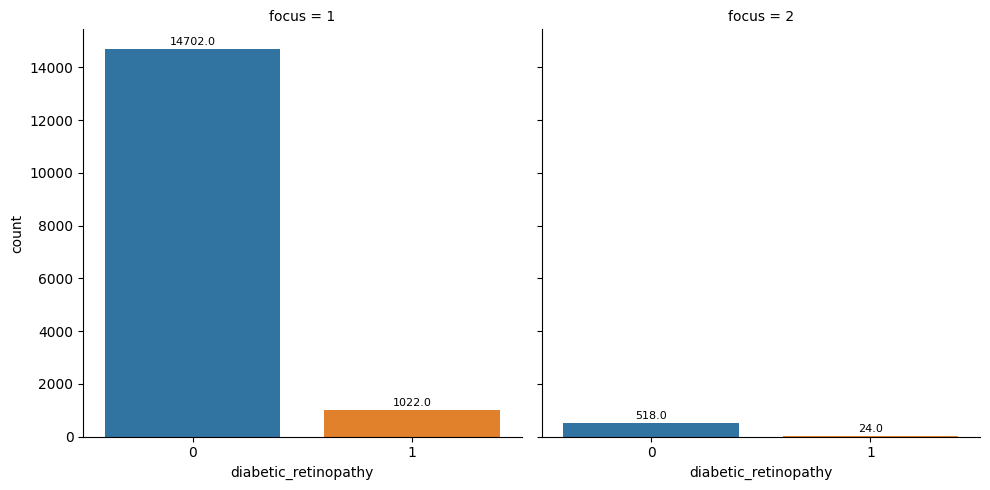


diabetic_retinopathy vs iluminaton



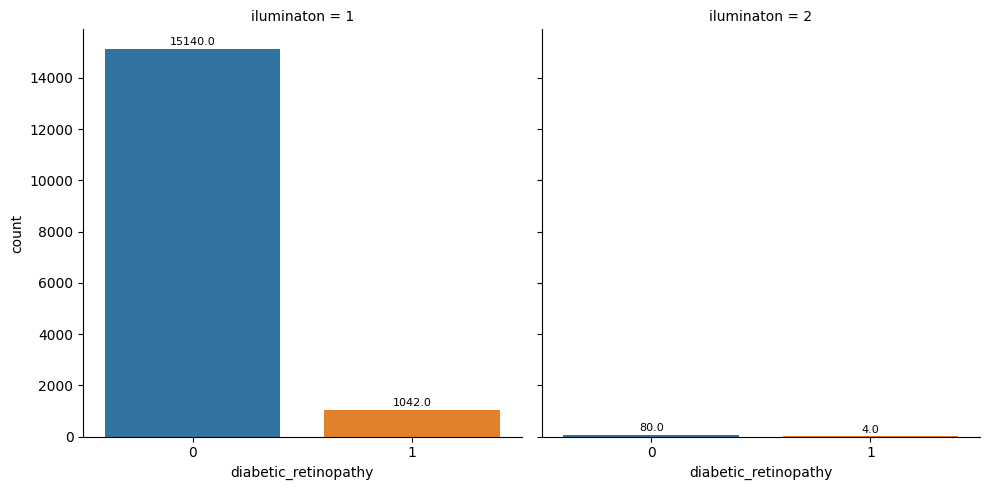


diabetic_retinopathy vs image_field



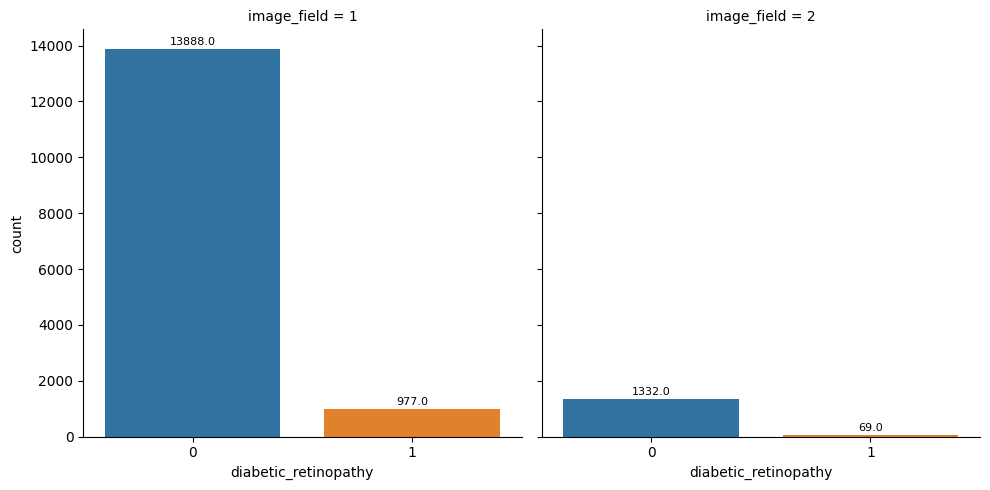


diabetic_retinopathy vs artifacts



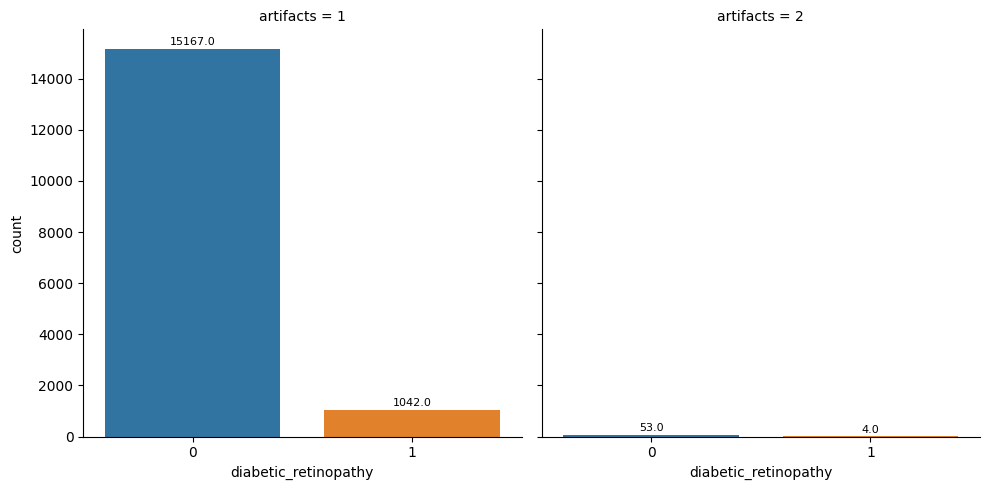


diabetic_retinopathy vs patient_sex



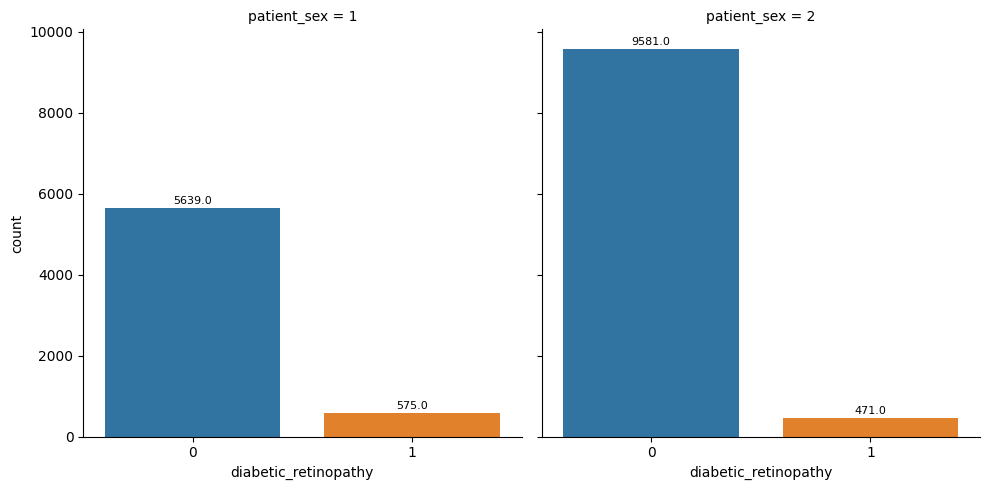


diabetic_retinopathy vs exam_eye



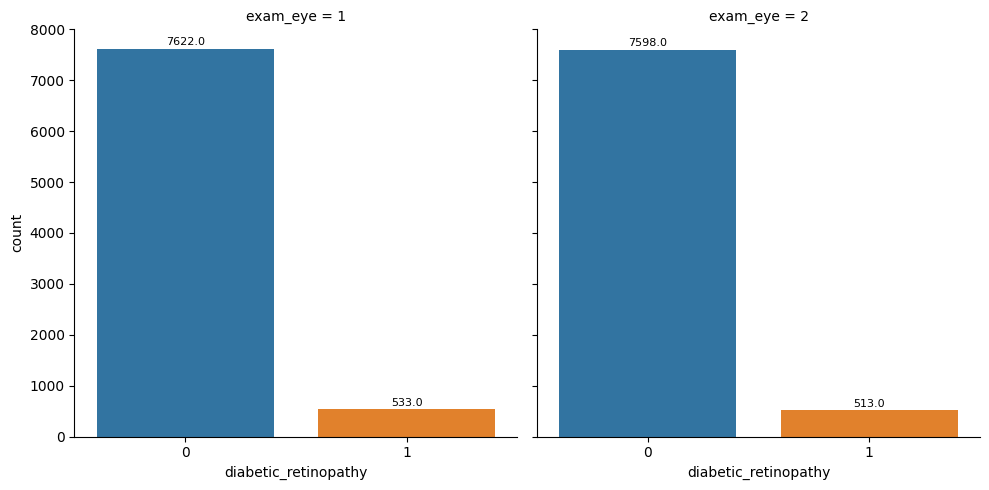


diabetic_retinopathy vs vessels



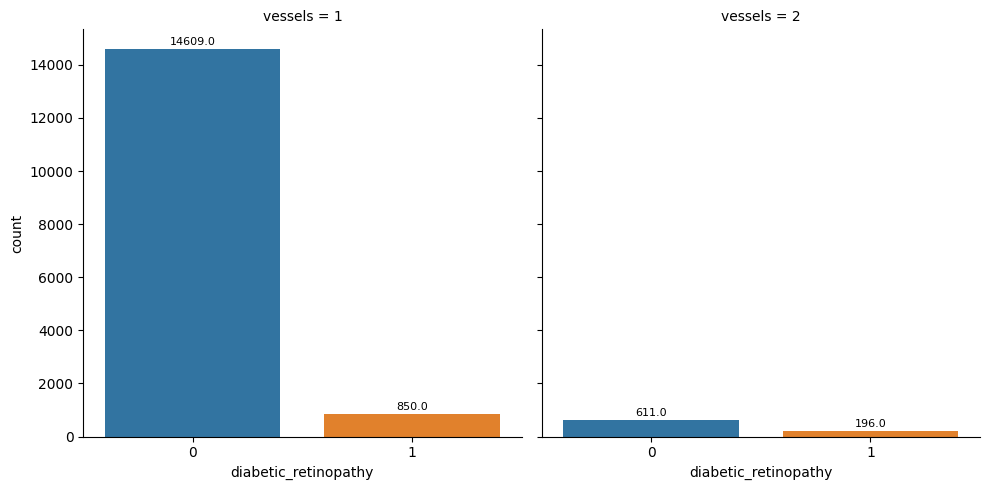


diabetic_retinopathy vs macula



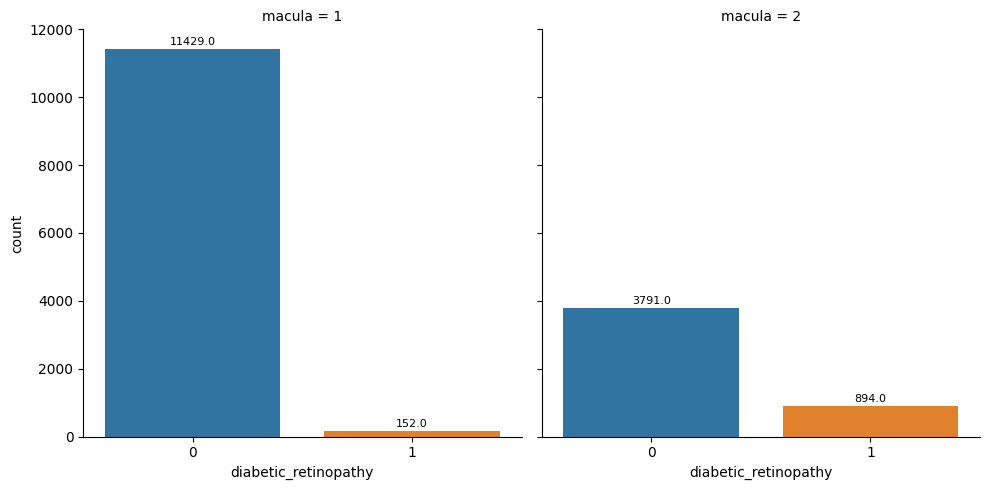


diabetic_retinopathy vs macular_edema



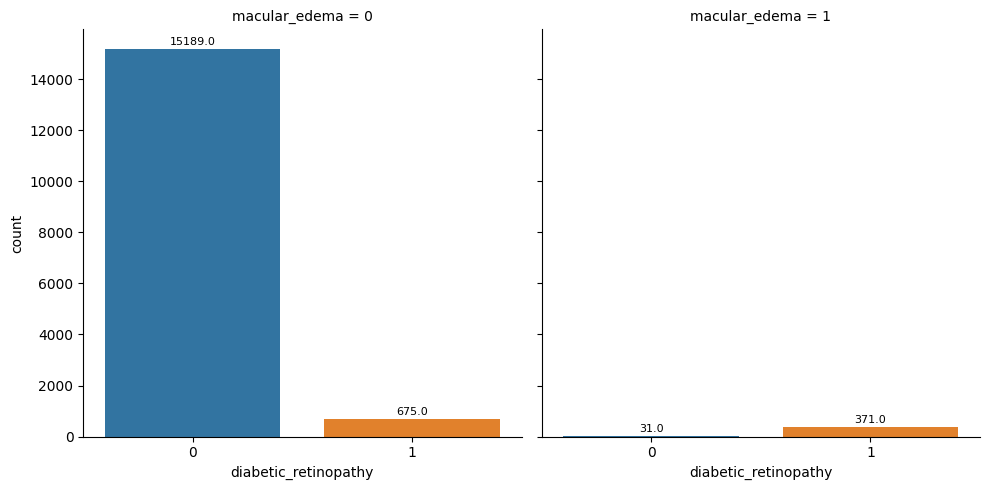


diabetic_retinopathy vs scar



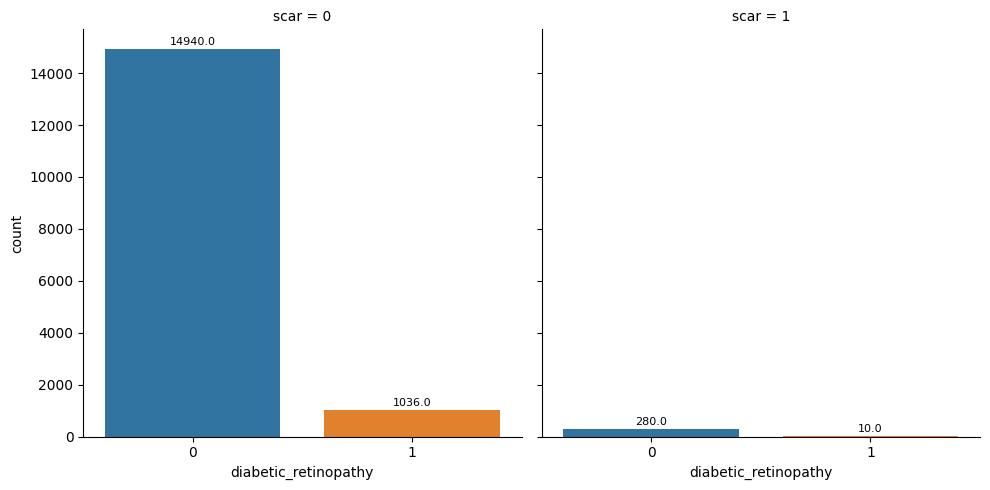


diabetic_retinopathy vs nevus



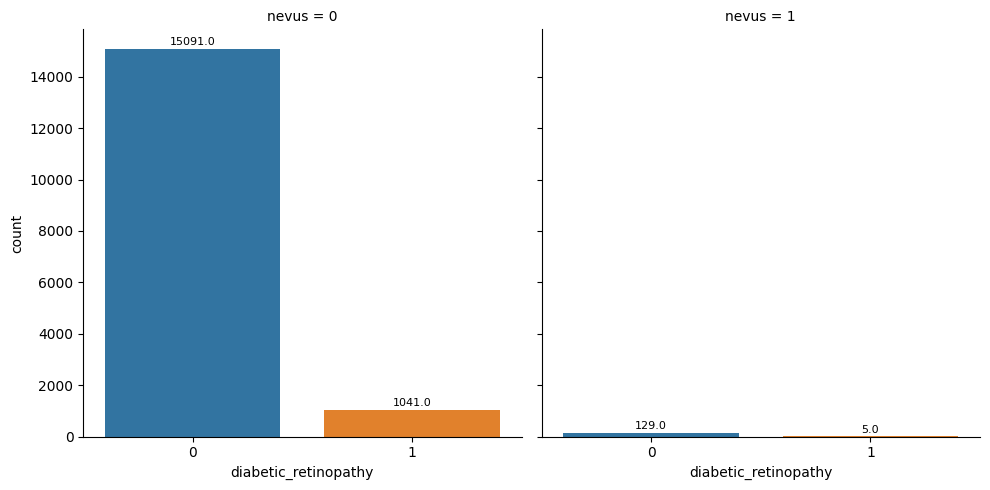


diabetic_retinopathy vs amd



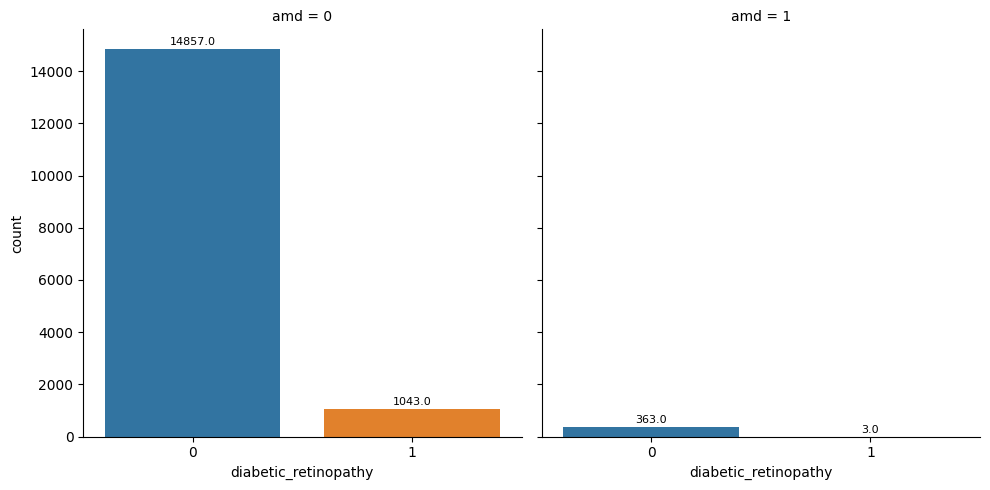


diabetic_retinopathy vs vascular_occlusion



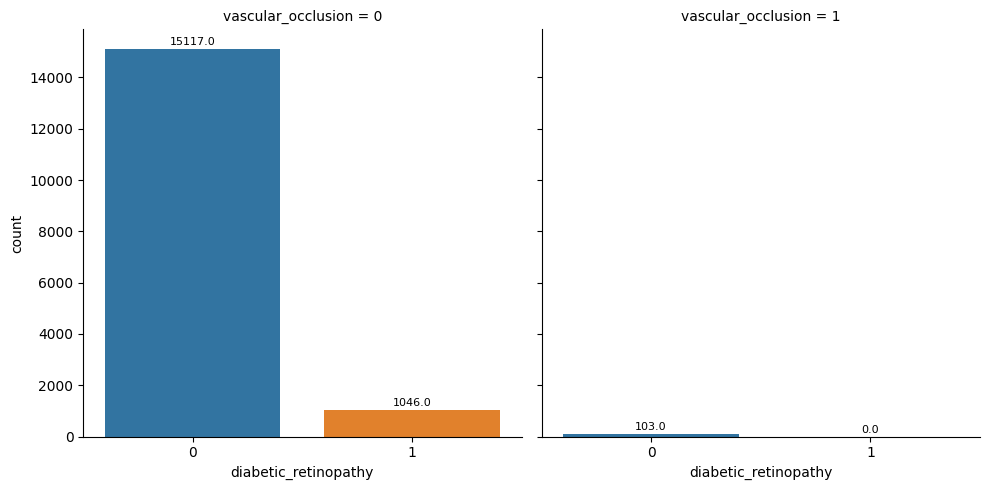


diabetic_retinopathy vs drusens



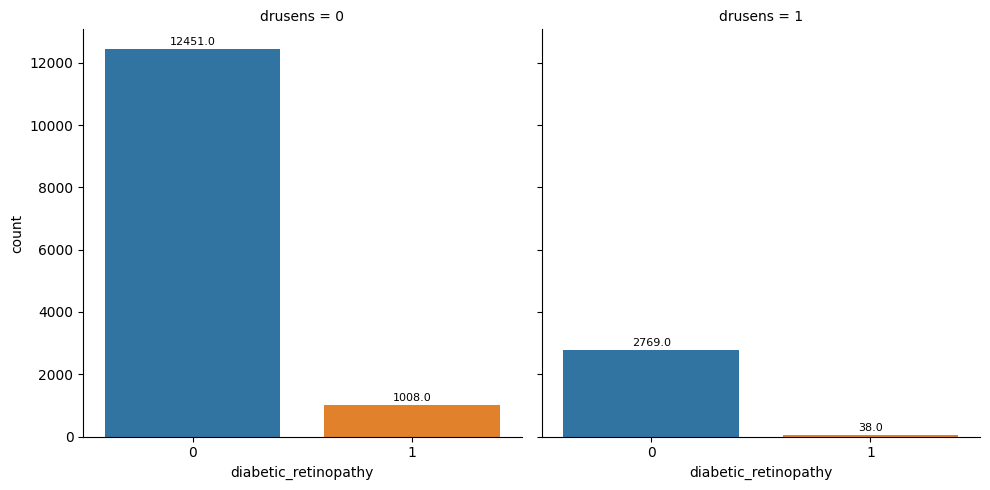


diabetic_retinopathy vs hemorrhage



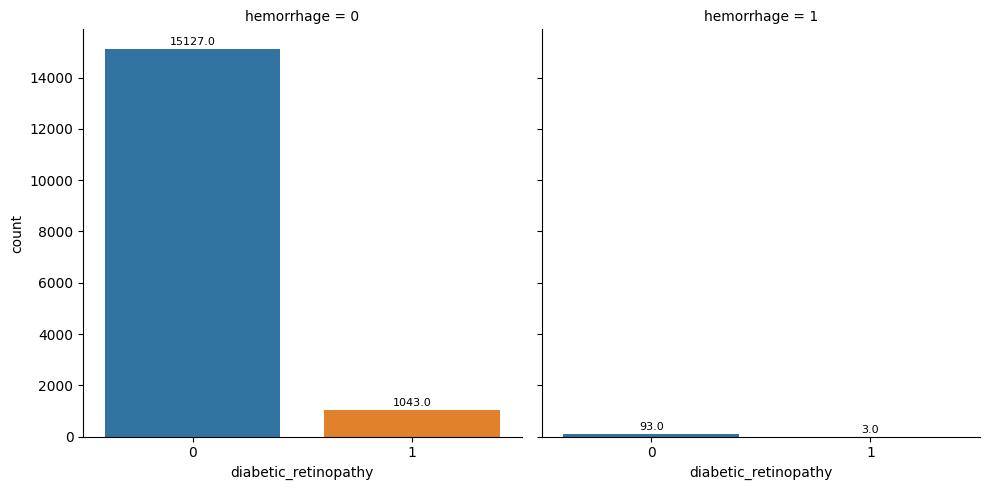


diabetic_retinopathy vs retinal_detachment



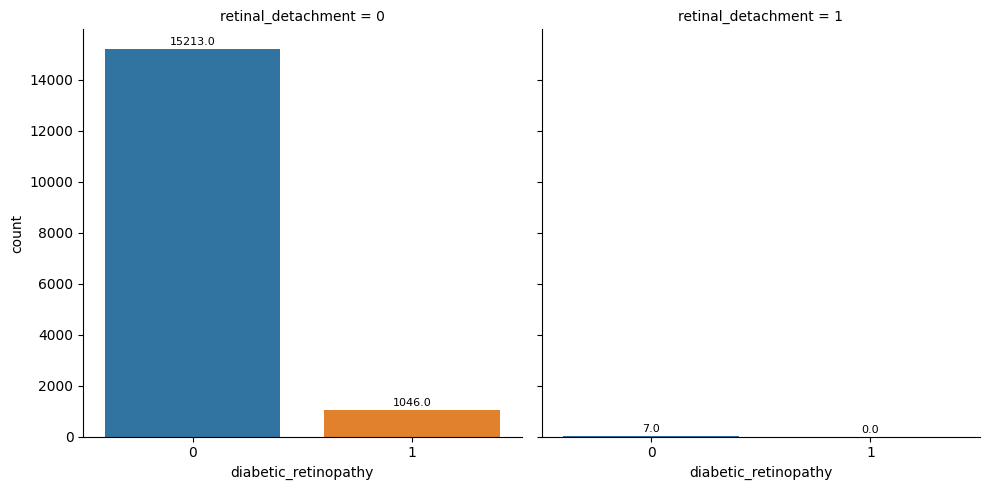


diabetic_retinopathy vs myopic_fundus



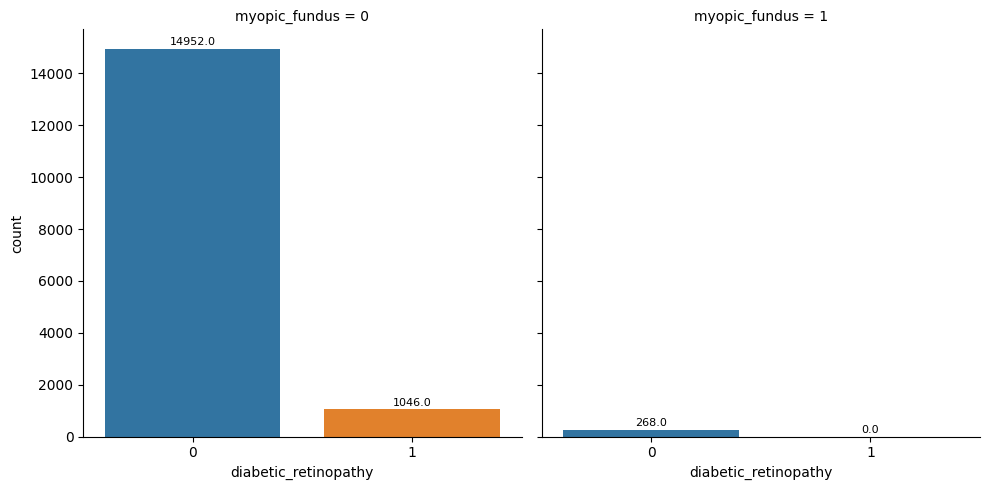


diabetic_retinopathy vs increased_cup_disc



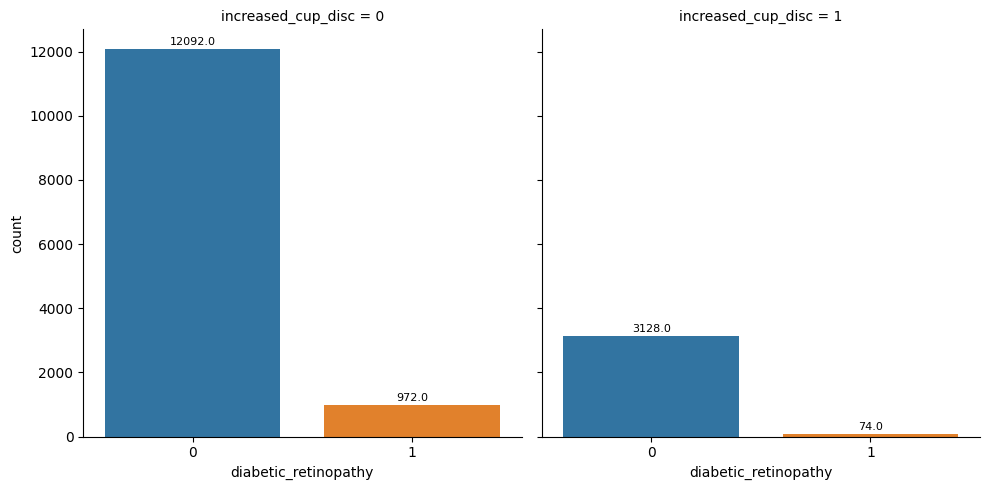


diabetic_retinopathy vs other



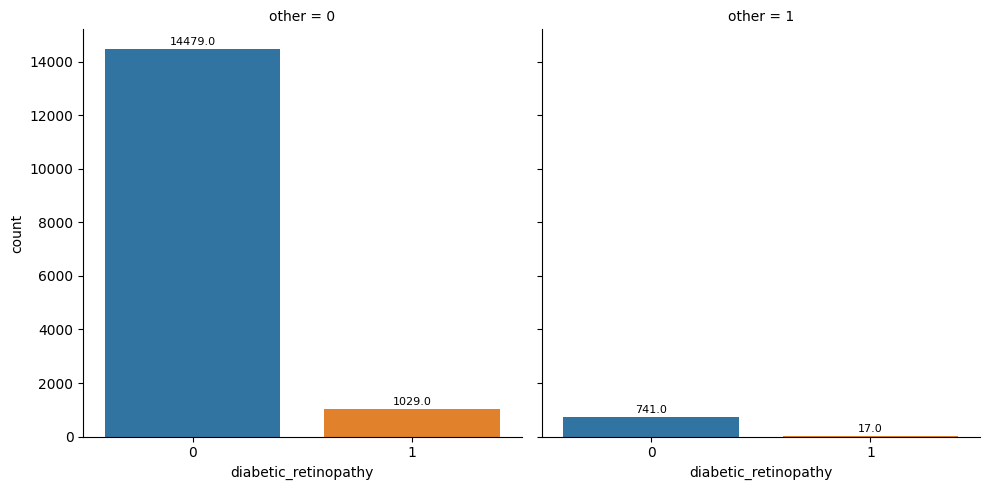


diabetic_retinopathy vs camera_Canon CR



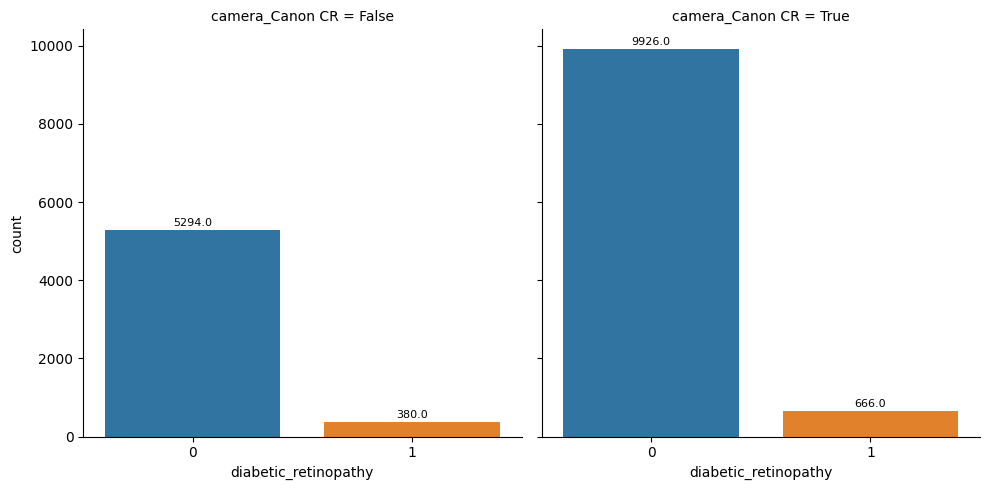


diabetic_retinopathy vs camera_NIKON NF5050



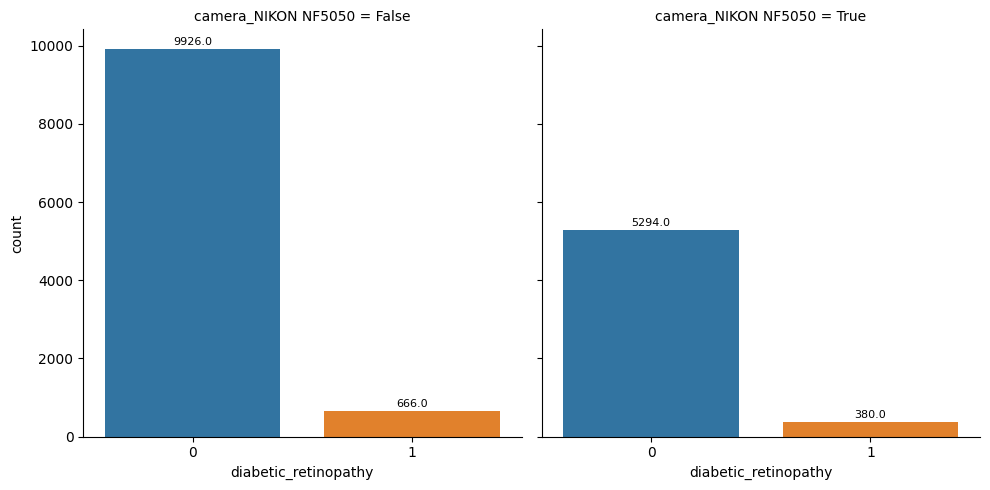


diabetic_retinopathy vs optic_disc_1



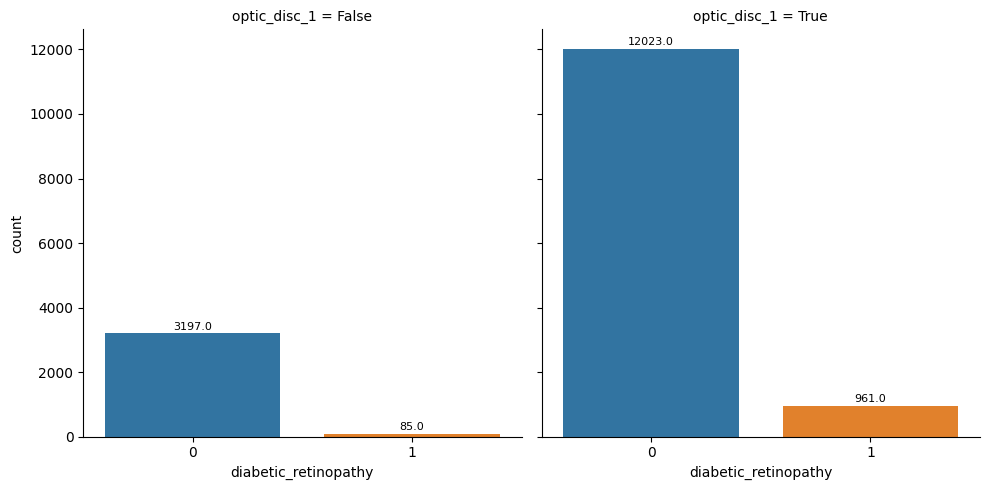


diabetic_retinopathy vs optic_disc_2



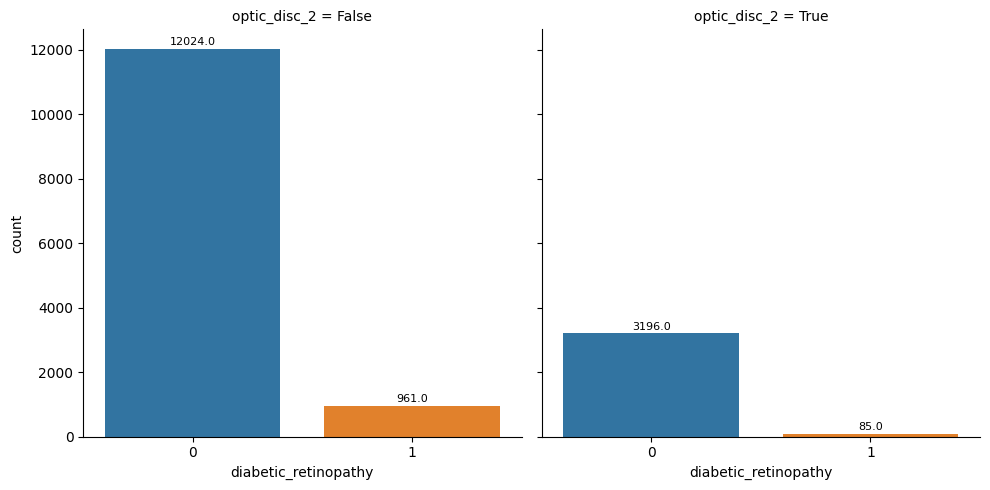


diabetic_retinopathy vs optic_disc_bv



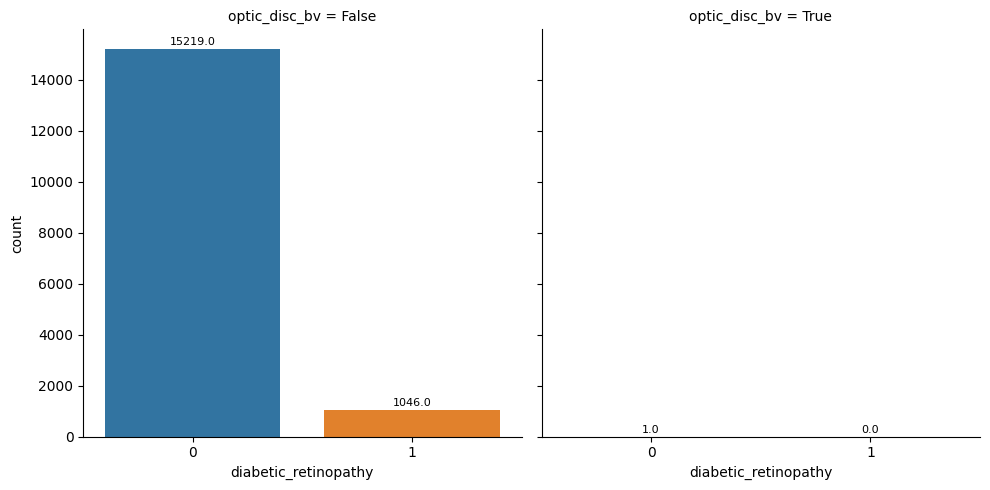


diabetic_retinopathy vs diabetes_no



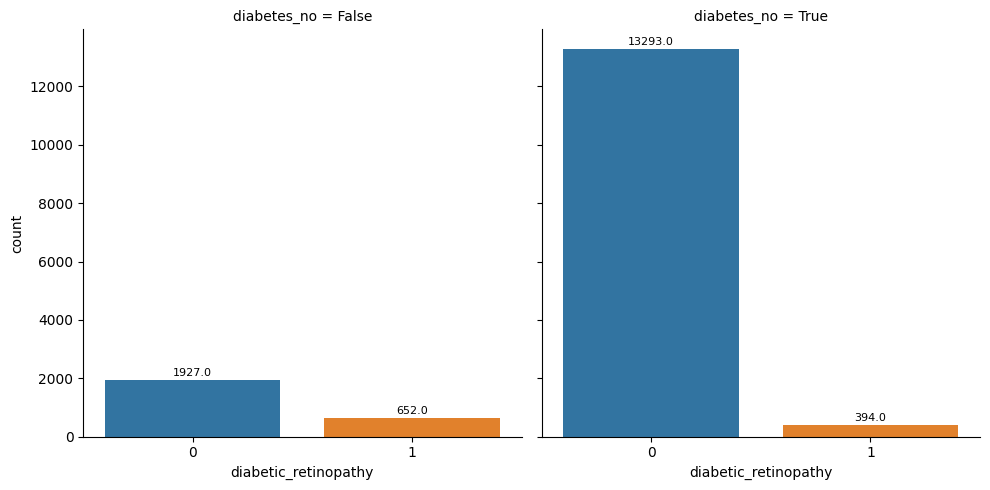


diabetic_retinopathy vs diabetes_yes



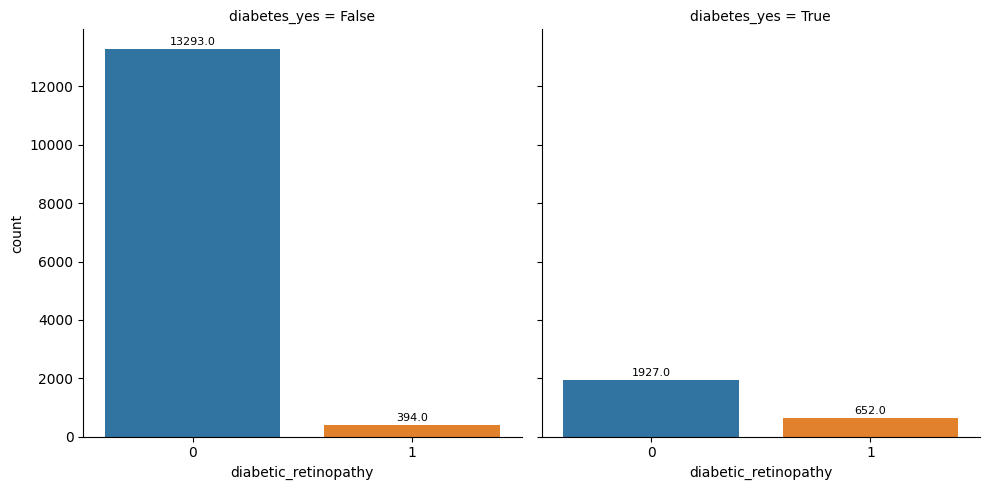

In [10]:
reference_variable = 'diabetic_retinopathy'
quality_variables = ['focus', 'iluminaton', 'image_field', 'artifacts', 'patient_sex', 'exam_eye', 'vessels', 'macula'
                     , 'macular_edema', 'scar', 'nevus', 'amd', 'vascular_occlusion', 'drusens', 'hemorrhage', 
                     'retinal_detachment', 'myopic_fundus', 'increased_cup_disc', 'other', 'camera_Canon CR',
                     'camera_NIKON NF5050', 'optic_disc_1', 'optic_disc_2', 'optic_disc_bv', 'diabetes_no', 'diabetes_yes']
plot_distribution(df, reference_variable, quality_variables)


DR_ICDR vs focus



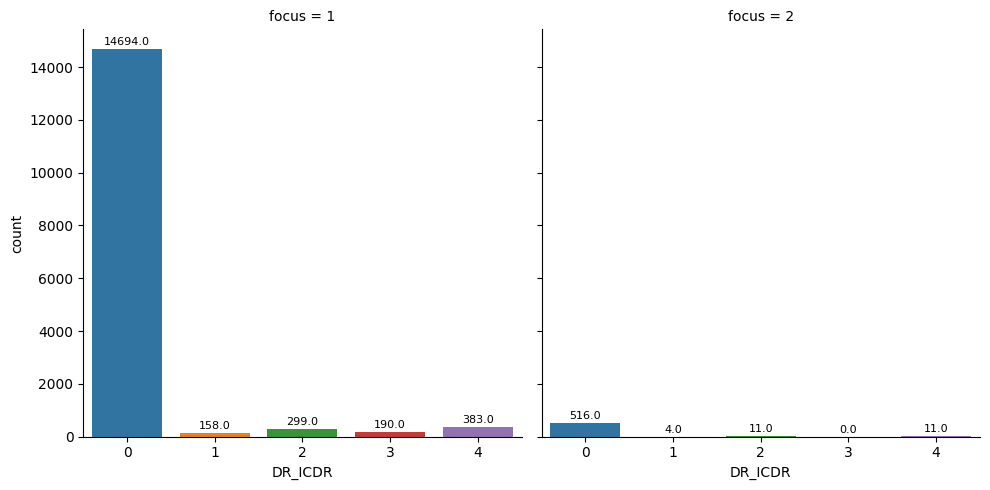


DR_ICDR vs iluminaton



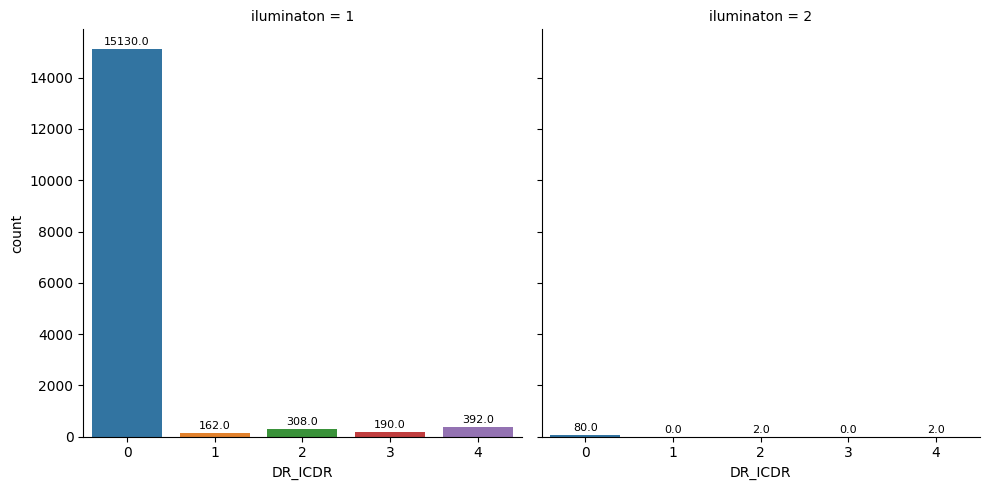


DR_ICDR vs image_field



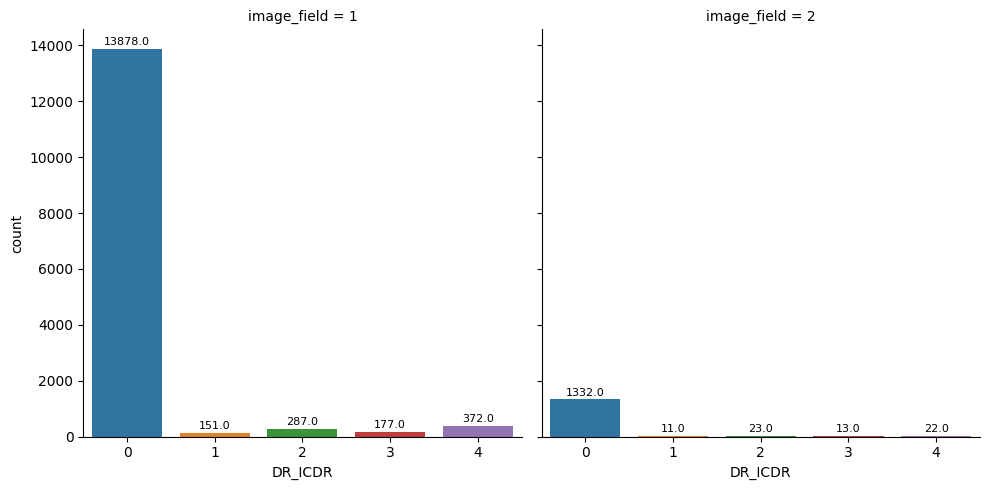


DR_ICDR vs artifacts



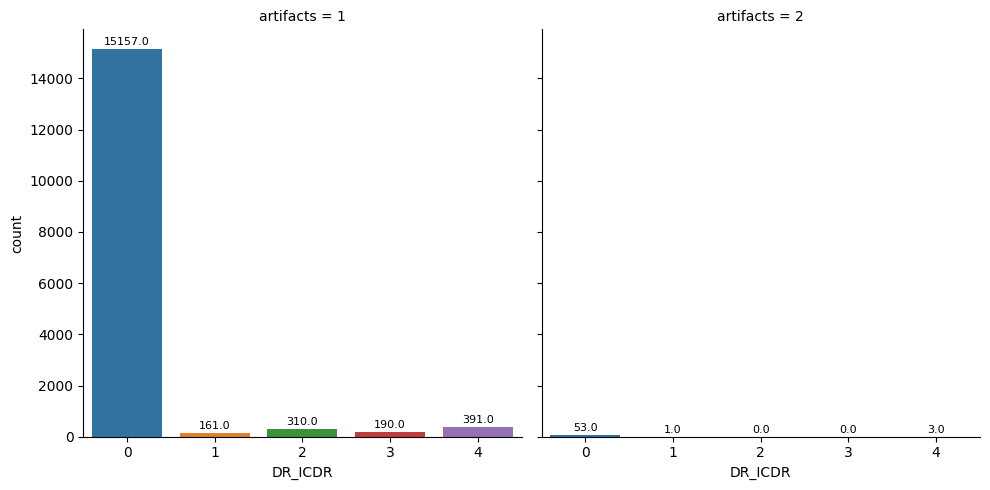


DR_ICDR vs patient_sex



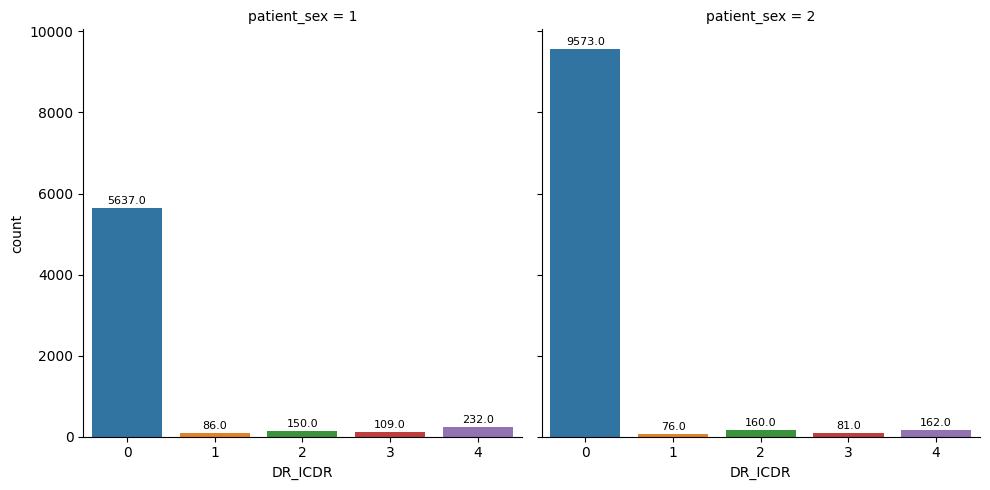


DR_ICDR vs exam_eye



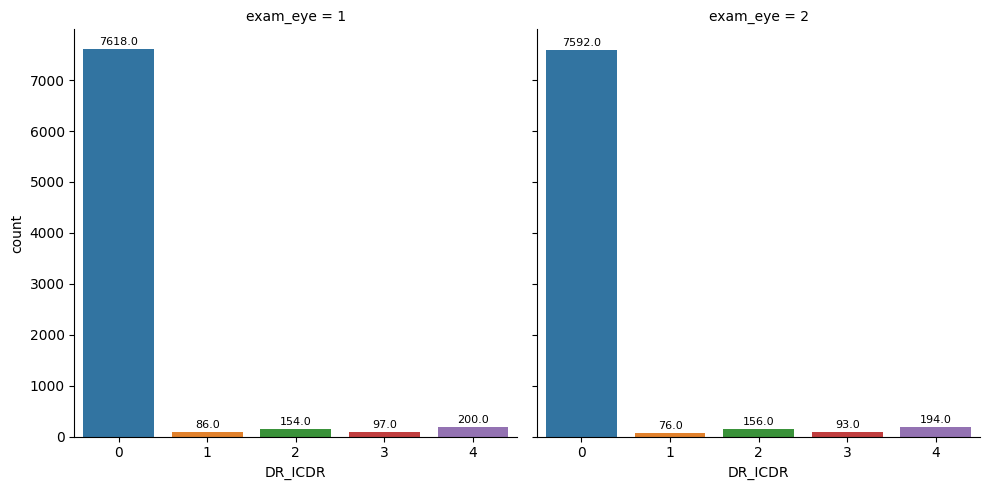


DR_ICDR vs vessels



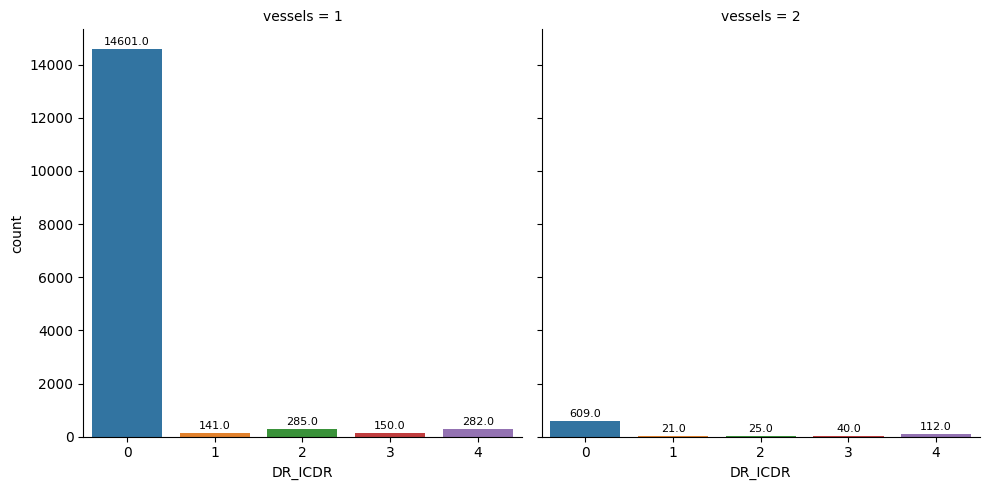


DR_ICDR vs macula



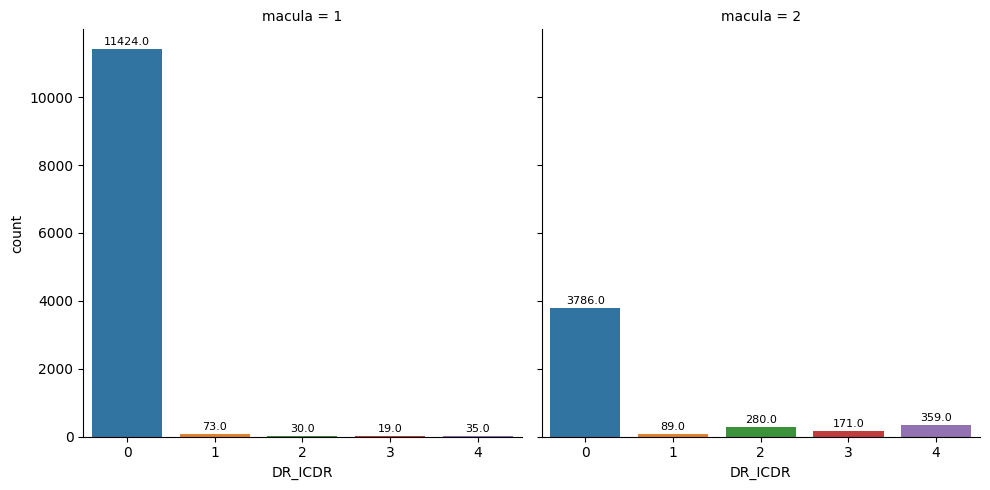


DR_ICDR vs macular_edema



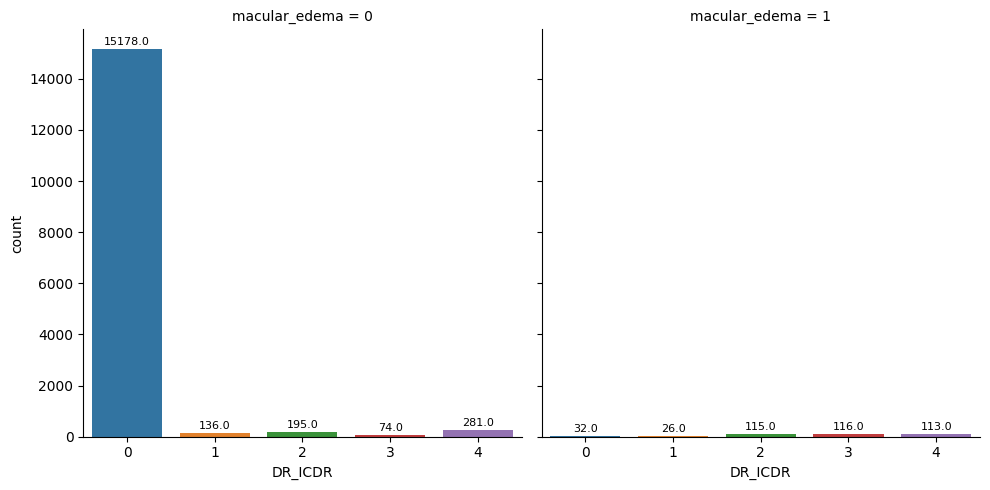


DR_ICDR vs scar



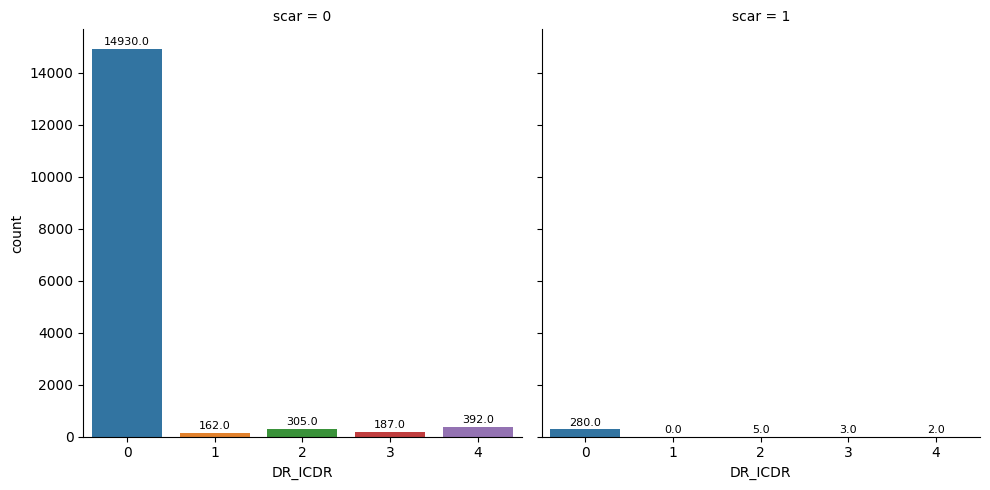


DR_ICDR vs nevus



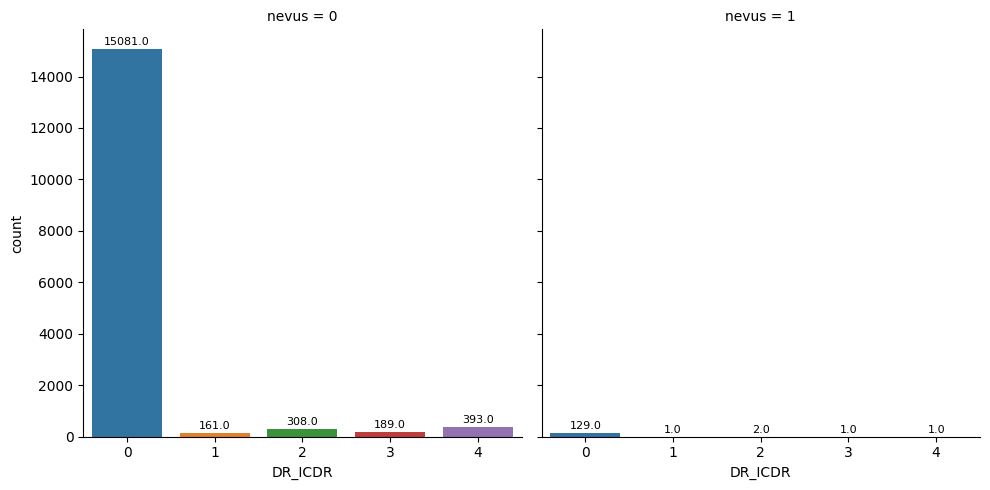


DR_ICDR vs amd



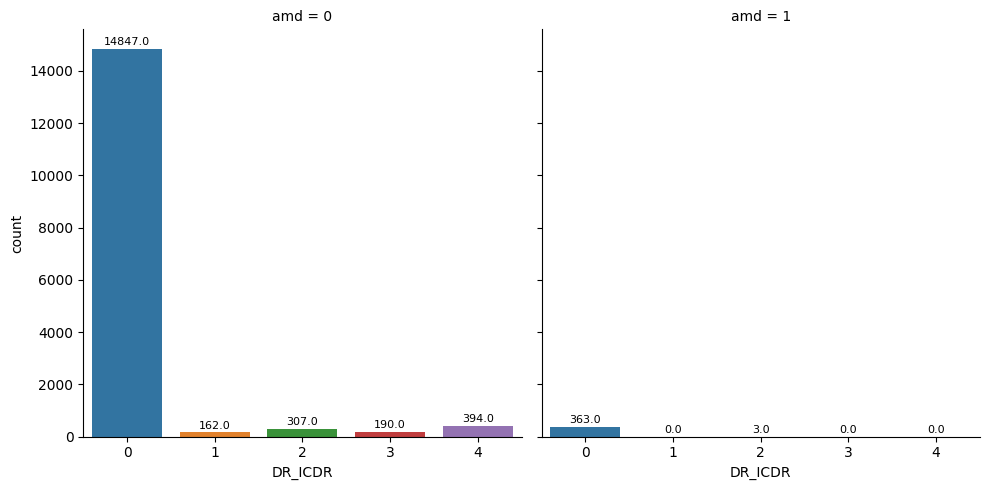


DR_ICDR vs vascular_occlusion



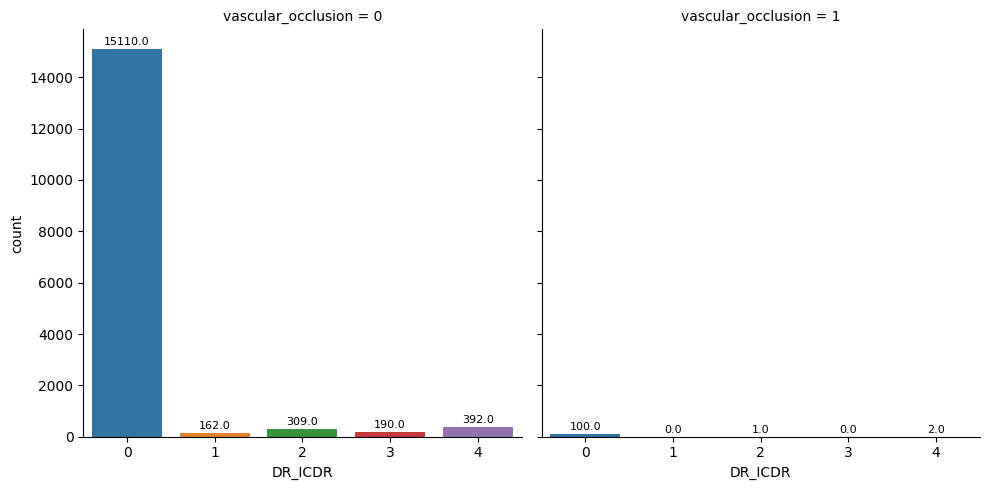


DR_ICDR vs drusens



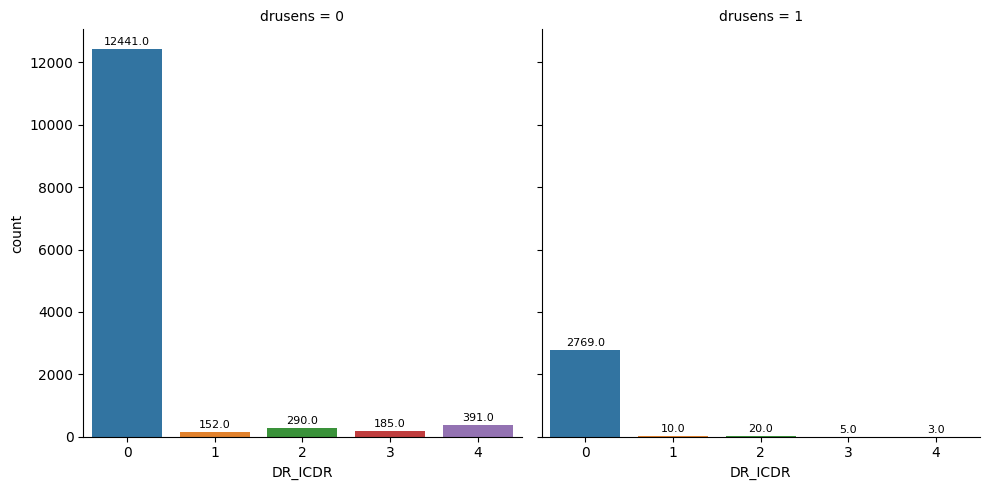


DR_ICDR vs hemorrhage



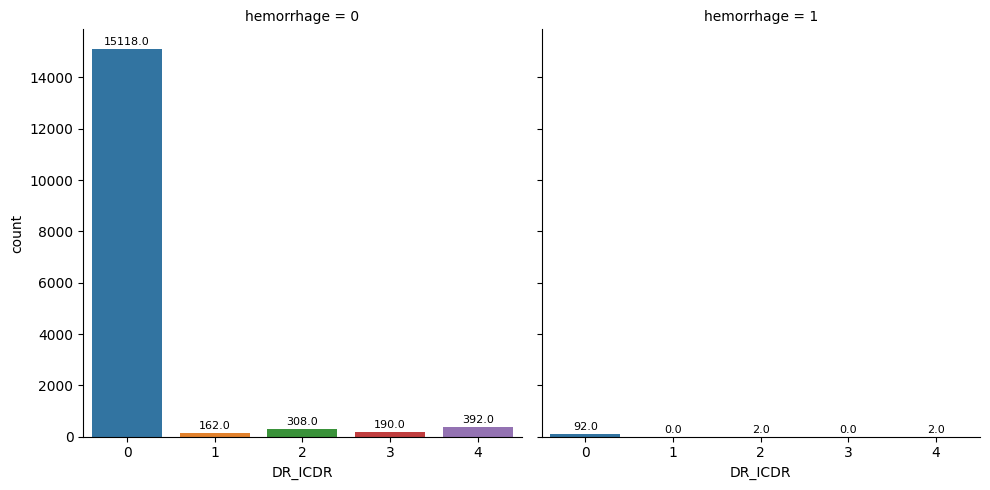


DR_ICDR vs retinal_detachment



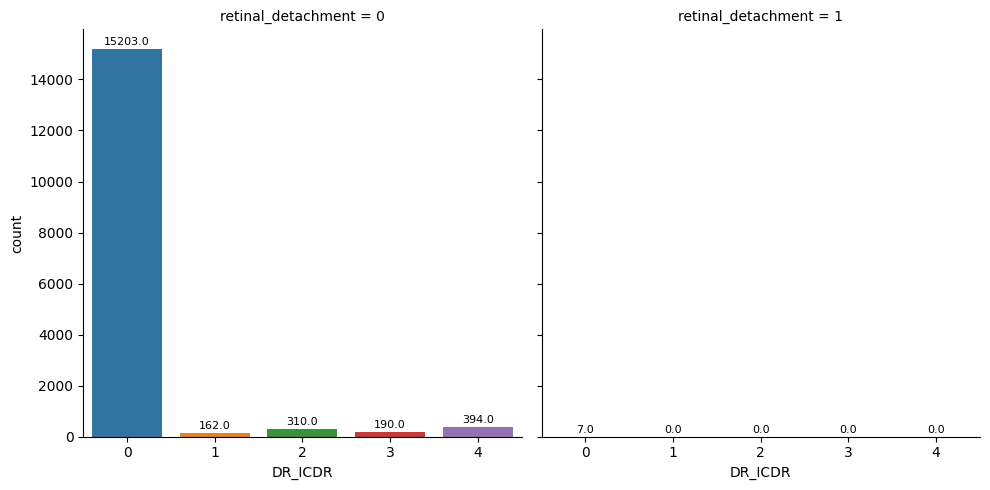


DR_ICDR vs myopic_fundus



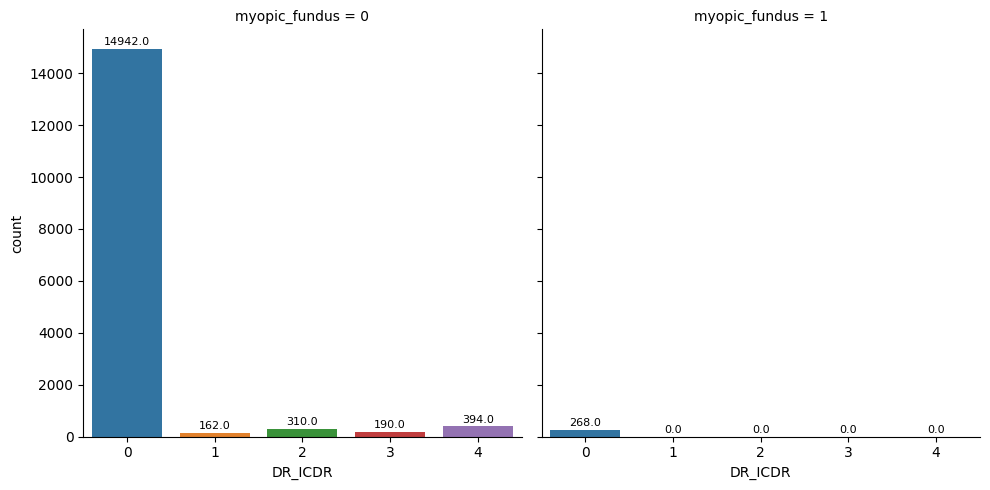


DR_ICDR vs increased_cup_disc



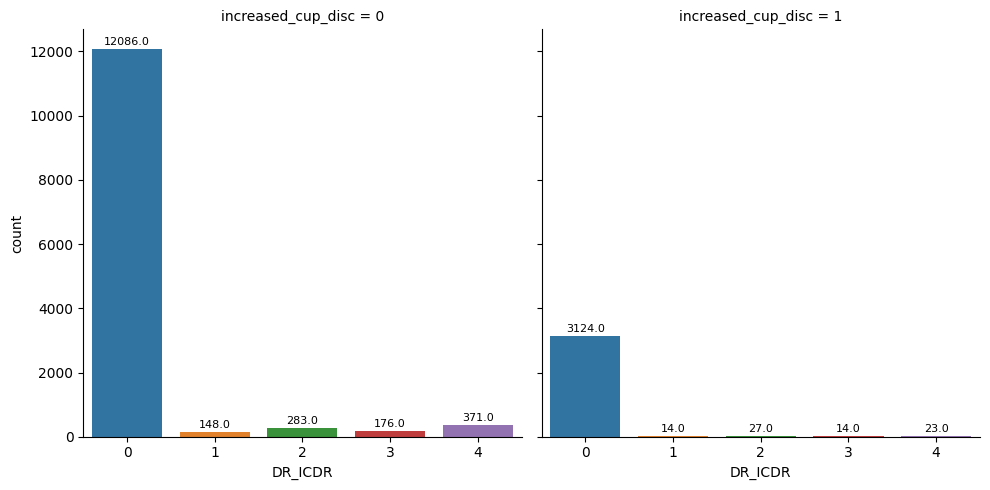


DR_ICDR vs other



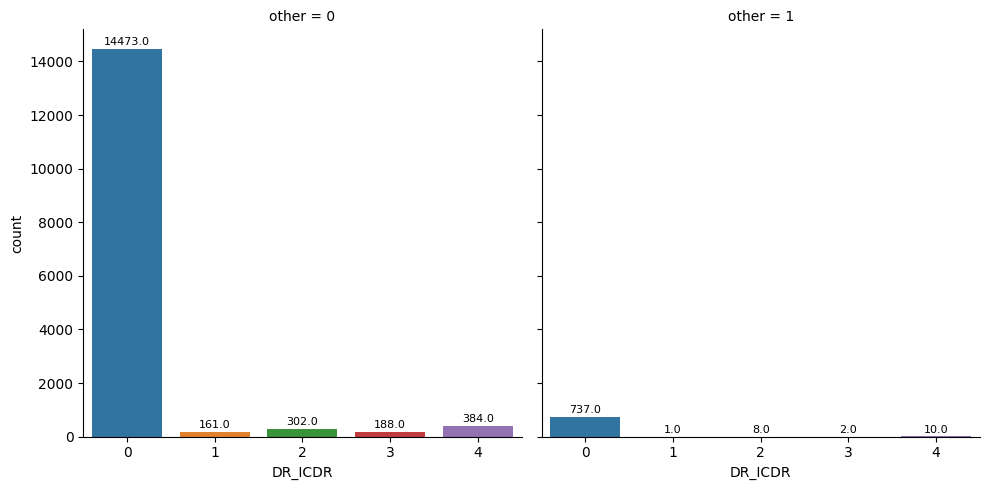


DR_ICDR vs camera_Canon CR



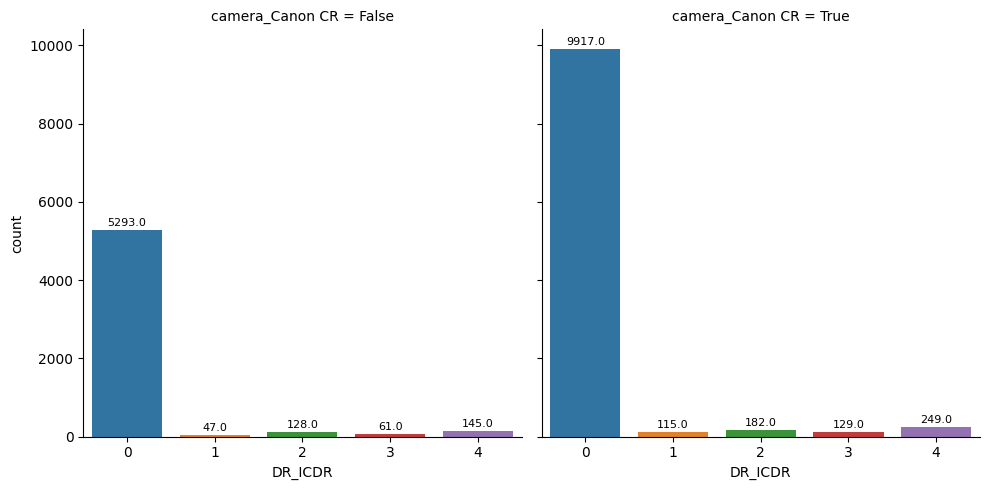


DR_ICDR vs camera_NIKON NF5050



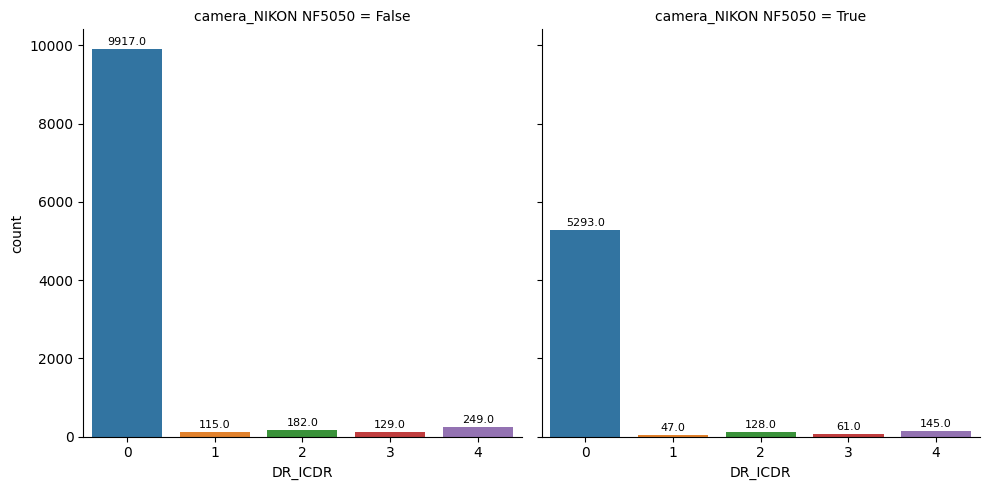


DR_ICDR vs optic_disc_1



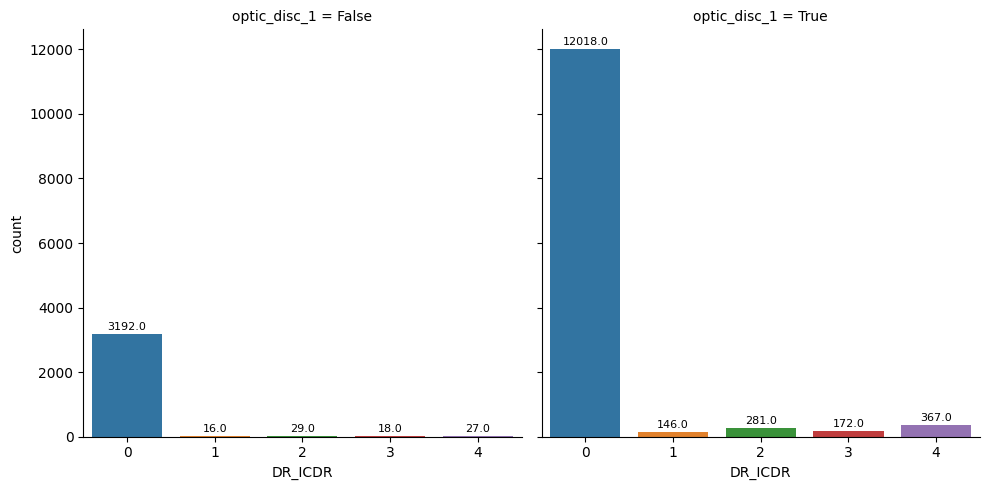


DR_ICDR vs optic_disc_2



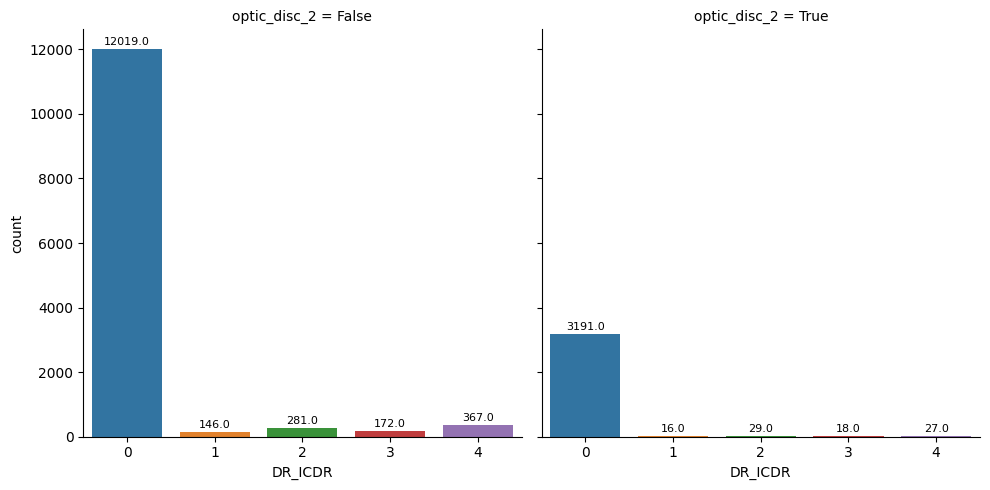


DR_ICDR vs optic_disc_bv



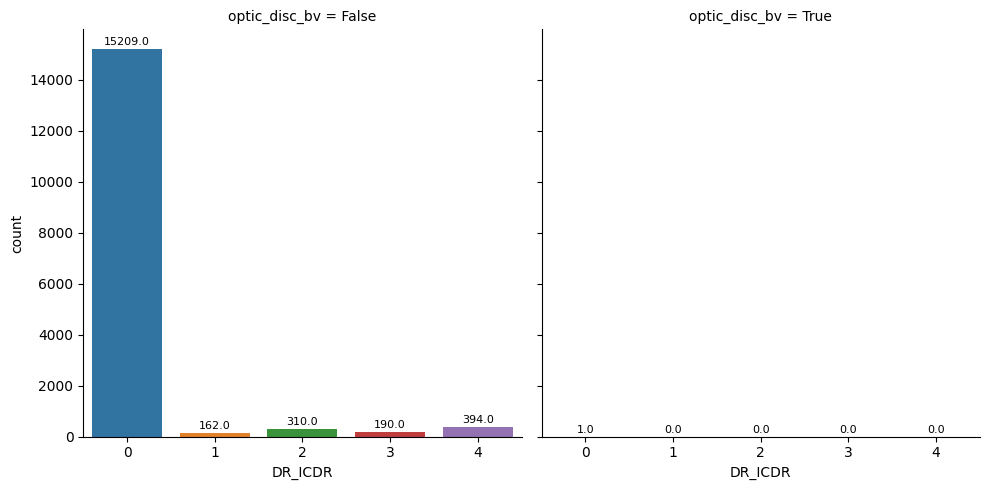


DR_ICDR vs diabetes_no



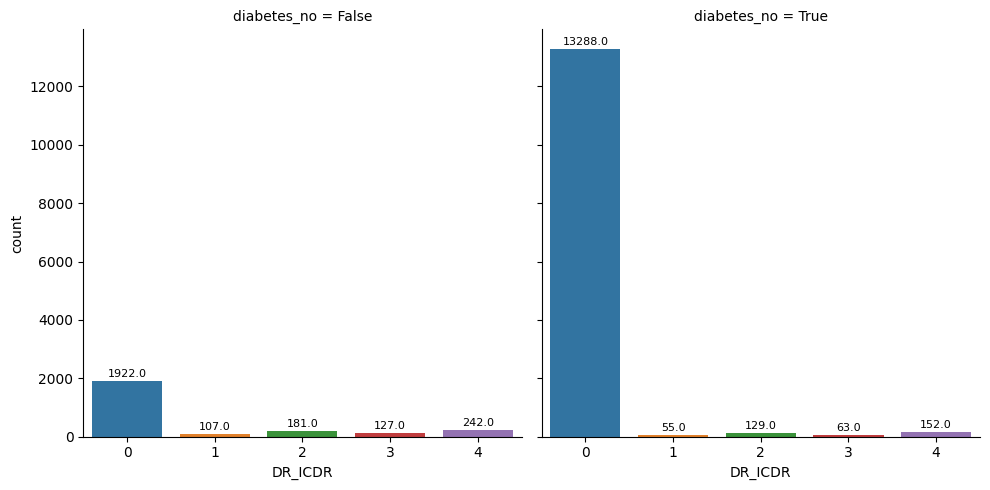


DR_ICDR vs diabetes_yes



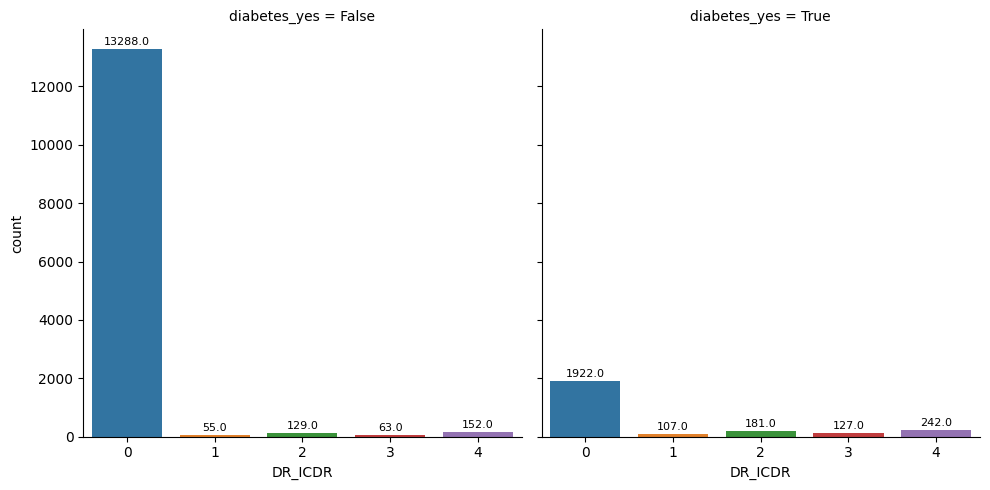

In [11]:
reference_variable = 'DR_ICDR'
quality_variables = ['focus', 'iluminaton', 'image_field', 'artifacts', 'patient_sex', 'exam_eye', 'vessels', 'macula'
                     , 'macular_edema', 'scar', 'nevus', 'amd', 'vascular_occlusion', 'drusens', 'hemorrhage', 
                     'retinal_detachment', 'myopic_fundus', 'increased_cup_disc', 'other', 'camera_Canon CR',
                     'camera_NIKON NF5050', 'optic_disc_1', 'optic_disc_2', 'optic_disc_bv', 'diabetes_no', 'diabetes_yes']
plot_distribution(df, reference_variable, quality_variables)


patient_sex vs focus



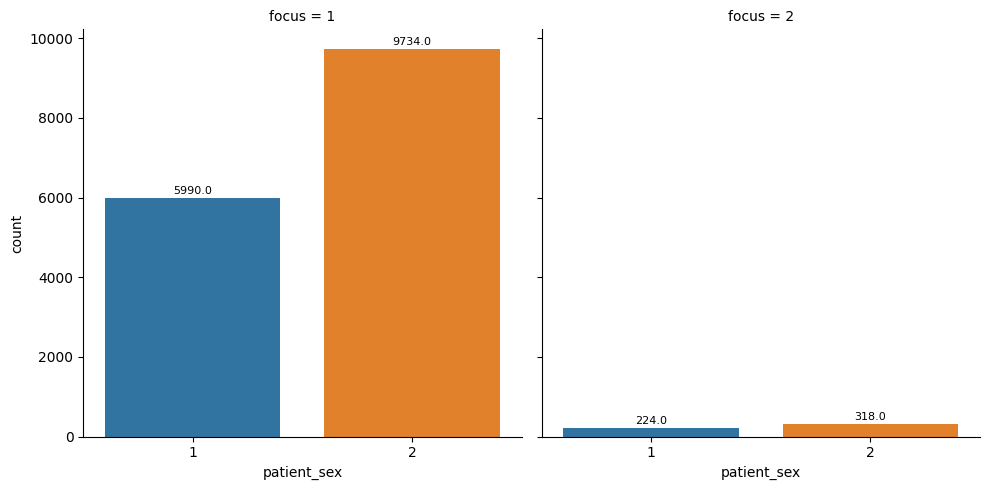


patient_sex vs iluminaton



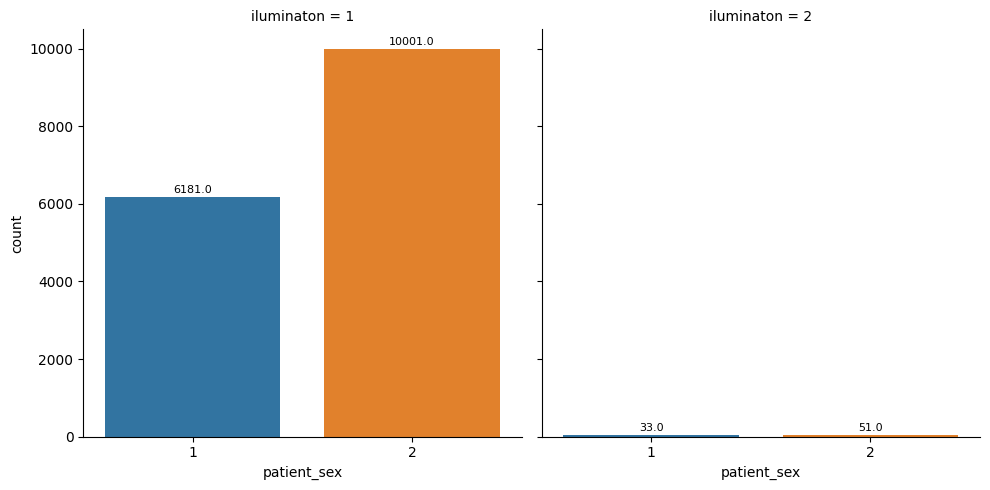


patient_sex vs image_field



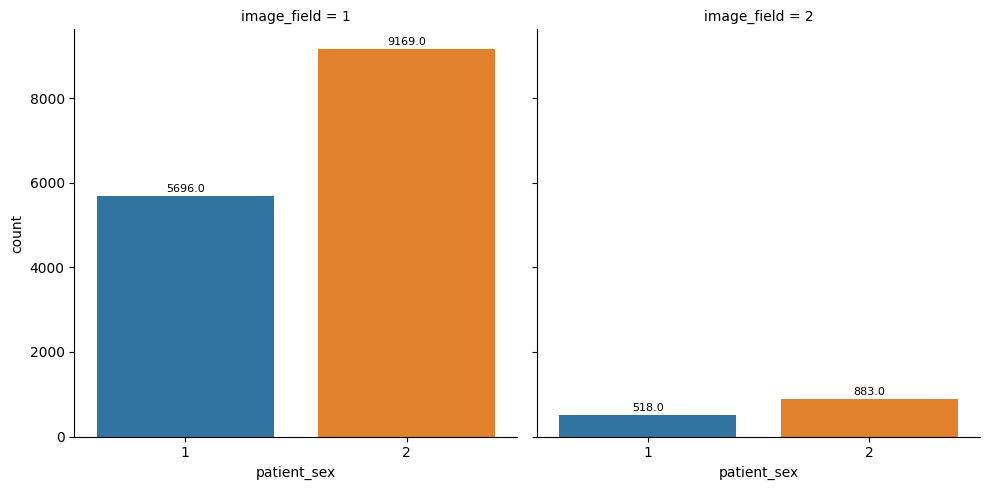


patient_sex vs artifacts



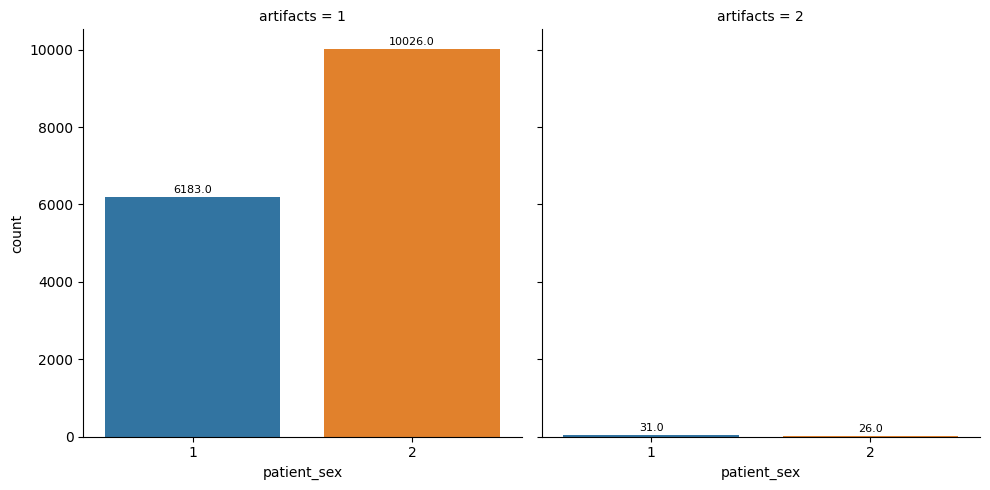

In [12]:
reference_variable = 'patient_sex'
quality_variables = ['focus', 'iluminaton', 'image_field', 'artifacts']
plot_distribution(df, reference_variable, quality_variables)

### Correlations:

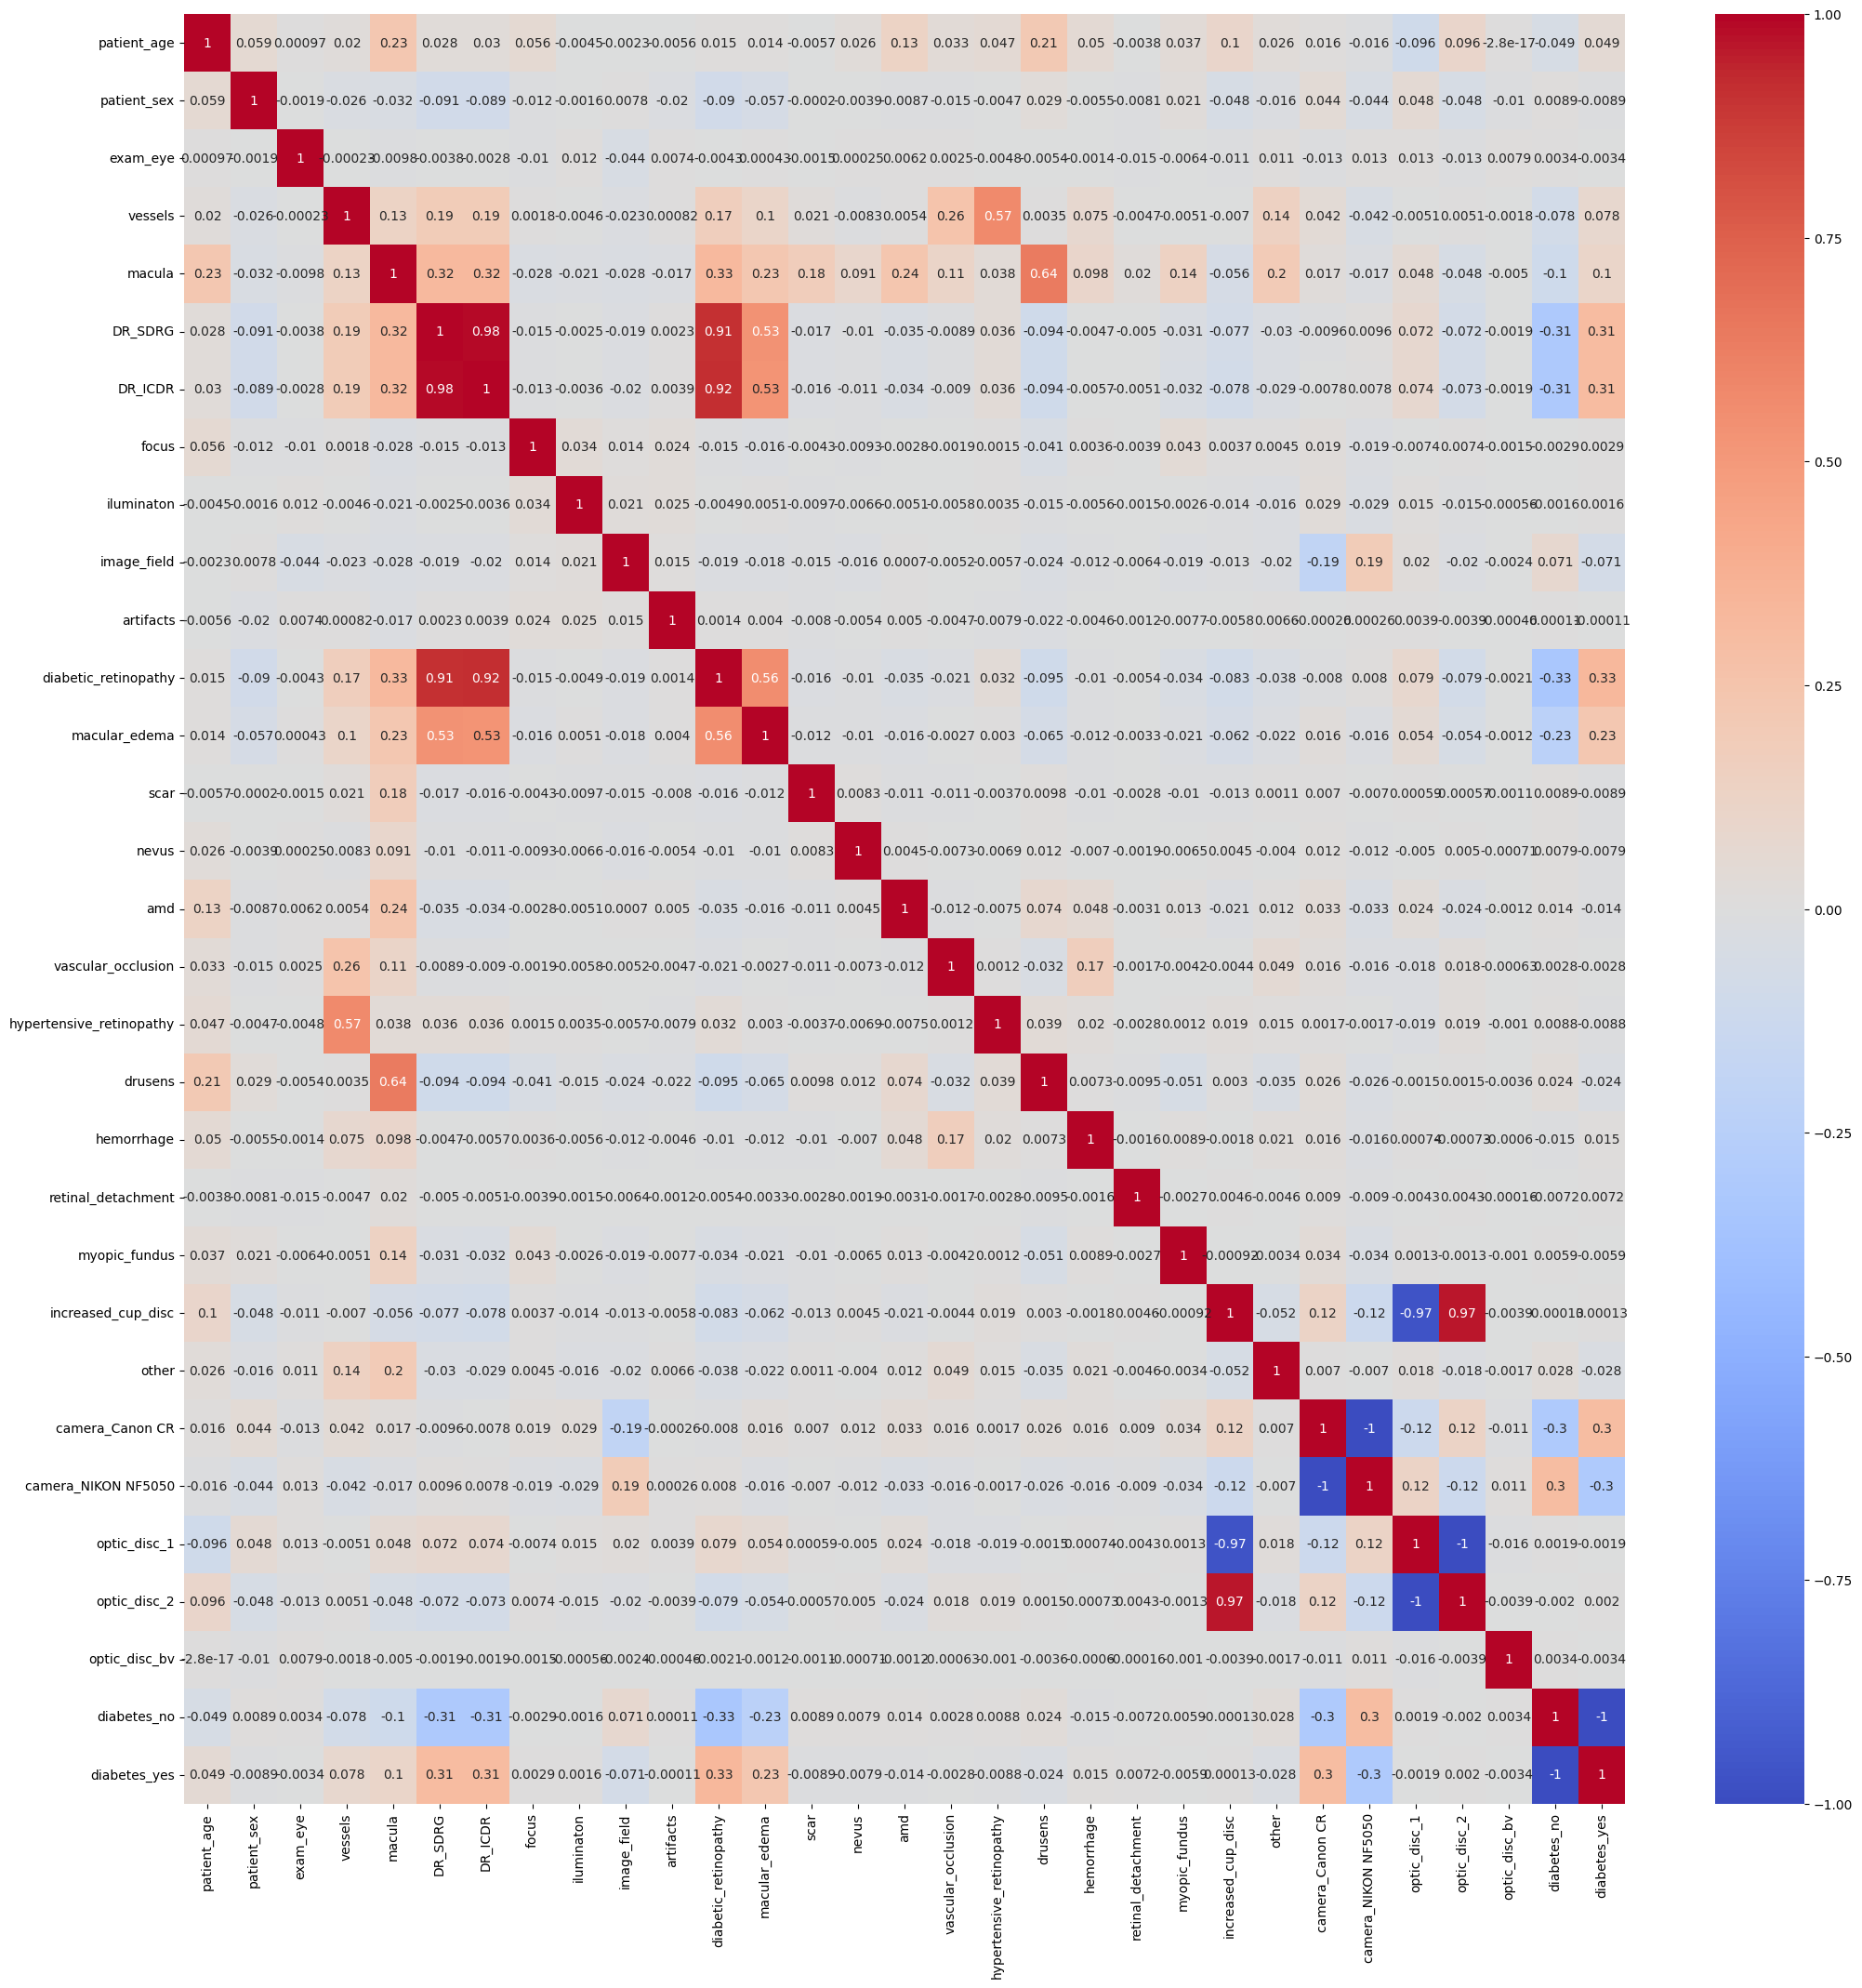

In [13]:
# Calculate the correlation:
correlation_matrix = df.corr()
# Set figure size:
plt.figure(figsize=(25, 25))
# Plot a heat map with the correlation:
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
# Show plot:
plt.show()

### Let's train some ML models

Here we'll train a Logistic Regression and a Random Forest because are simple and easy-to-interpret models.

The idea is to train a ML model to predict any certain disease (E.g. Diabetic Retinopathy) and analyze the results. We'll se how other variables affect the prediction and the influence.

In [14]:
def prune_tree(X_train, y_train, dt_model, y_test, X_test, ccp_alpha, verbose=False, class_weights=None):
    """
    Prunes a Decision Tree model using cost complexity pruning and evaluates the pruned model's performance.

    Parameters:
    - X_train (pd.DataFrame): Features of the training set.
    - y_train (pd.Series): Labels of the training set.
    - dt_model (DecisionTreeClassifier): Original Decision Tree model to be pruned.
    - X_test (pd.DataFrame): Features of the test set.
    - y_test (pd.Series): Labels of the test set.
    - ccp_alpha (float): Hyperparameter for cost complexity pruning.
    - verbose (bool, optional): If True, display plots for alpha, impurity, and accuracy scores during pruning. Default is False.
    - class_weights (dict, optional): Dictionary of class weights for handling imbalanced datasets. Default is None.

    Returns:
    None

    Example:
    >>> prune_tree(X_train, y_train, dt_model, y_test, X_test, ccp_alpha=0.001, verbose=True, class_weights=None)
    """
    print("")
    print('#'*40, " Pruning tree ", '#'*40)
    print("")
    ### Pruning
    # Prune Decision Tree using cost complexity pruning
    path = dt_model.cost_complexity_pruning_path(X_train, y_train)
    ccp_alphas, impurities = path.ccp_alphas, path.impurities

    if verbose:
        plt.figure(figsize=(10, 6))
        plt.plot(ccp_alphas, impurities)
        plt.xlabel("effective alpha")
        plt.ylabel("total impurity of leaves")
        plt.show()

    clfs = []

    for ccp_alpha in ccp_alphas:
        clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
        clf.fit(X_train, y_train)
        clfs.append(clf)

    tree_depths = [clf.tree_.max_depth for clf in clfs]
    if verbose:
        plt.figure(figsize=(10,  6))
        plt.plot(ccp_alphas[:-1], tree_depths[:-1])
        plt.xlabel("effective alpha")
        plt.ylabel("total depth")
        plt.show()

    acc_scores = [accuracy_score(y_test, clf.predict(X_test)) for clf in clfs]

    tree_depths = [clf.tree_.max_depth for clf in clfs]
    plt.figure(figsize=(10,  6))
    plt.grid()
    plt.plot(ccp_alphas[:-1], acc_scores[:-1])
    plt.xlabel("effective alpha")
    plt.ylabel("Accuracy scores")
    plt.show()

    # Prune the tree
    # Choose the best alpha (minimum cross-validated error)
    best_alpha = ccp_alphas[impurities.argmin()]
    pruned_dt_model = DecisionTreeClassifier(ccp_alpha=0.002)
    if class_weights:
        pruned_dt_model.fit(X_train, y_train, sample_weight=y_train.map(class_weights))
    else:
        pruned_dt_model.fit(X_train, y_train)
    # Decision Tree with pruning
    y_pred_pruned_dt = pruned_dt_model.predict(X_test)

    # Analyze results after pruning
    print("Decision Tree Accuracy (with pruning):", accuracy_score(y_test, y_pred_pruned_dt))
    print("Decision Tree Classification Report (with pruning):\n", classification_report(y_test, y_pred_pruned_dt))

    # Feature Importance for Pruned Decision Tree
    pruned_dt_importance = pruned_dt_model.feature_importances_
    pruned_dt_importance_df = pd.DataFrame({'Feature': features, 'Importance': pruned_dt_importance})
    pruned_dt_importance_df = pruned_dt_importance_df.sort_values(by='Importance', ascending=False)

    print("\nPruned Decision Tree Feature Importance:")
    print(pruned_dt_importance_df)

    # Plot Pruned Decision Tree
    plt.figure(figsize=(30, 30))
    plot_tree(pruned_dt_model, filled=True, feature_names=features, class_names=[str(c) for c in y_train.unique()])
    plt.show()

In [15]:
def compute_and_apply_class_weights(y):
    """
    Computes class weights for an imbalanced target variable.

    Parameters:
    - y (pd.Series): Target variable (labels).

    Returns:
    - dict: Dictionary mapping class labels to their respective weights.

    Example:
    >>> class_weights = compute_and_apply_class_weights(y_train)
    """
    class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
    class_weight_dict = dict(zip(np.unique(y), class_weights))
    return class_weight_dict

def analyze_image_quality(df, target_variable, features, plot_tree=False, prune=True, ccp_alpha=0.001, verbose=False):
    """
    Prunes a Decision Tree model using cost complexity pruning and evaluates the pruned model's performance.

    Parameters:
    - X_train (pd.DataFrame): Features of the training set.
    - y_train (pd.Series): Labels of the training set.
    - dt_model (DecisionTreeClassifier): Original Decision Tree model to be pruned.
    - X_test (pd.DataFrame): Features of the test set.
    - y_test (pd.Series): Labels of the test set.
    - ccp_alpha (float): Hyperparameter for cost complexity pruning.
    - verbose (bool, optional): If True, display plots for alpha, impurity, and accuracy scores during pruning. Default is False.
    - class_weights (dict, optional): Dictionary of class weights for handling imbalanced datasets. Default is None.

    Returns:
    None

    Example:
    >>> prune_tree(X_train, y_train, dt_model, y_test, X_test, ccp_alpha=0.001, verbose=True, class_weights=None)
    """
    # Prepare data
    X = df[features]
    y = df[target_variable]

    # Normalize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Stratified train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    
    ###### SVM ######
    #print('#'*40, ' SVM ', '#'*40)
    #class_weights = compute_and_apply_class_weights(y_train)

    #logreg_model = SVC(class_weight=class_weights)
    #logreg_model.fit(X_train, y_train)
    #y_pred_logreg = logreg_model.predict(X_test)

    # Analyze results
    #print("SVM Accuracy:", accuracy_score(y_test, y_pred_logreg))
    #print("SVM Classification Report:\n", classification_report(y_test, y_pred_logreg))

    ###### Logistic Regression ######
    print('#'*40, ' Logistic Regression ', '#'*40)
    class_weights = compute_and_apply_class_weights(y_train)

    logreg_model = LogisticRegression(class_weight=class_weights)
    logreg_model.fit(X_train, y_train)
    y_pred_logreg = logreg_model.predict(X_test)

    # Analyze results
    print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_logreg))
    print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_logreg))

    # Feature Importance for Logistic Regression (coefficients)
    logreg_importance = logreg_model.coef_[0]
    logreg_importance_df = pd.DataFrame({'Feature': features, 'Importance': logreg_importance})
    logreg_importance_df = logreg_importance_df.sort_values(by='Importance', ascending=False)

    print("\nLogistic Regression Feature Importance:")
    print(logreg_importance_df)

    ###### Decision Tree ######
    print('#'*40, ' Decision Tree ', '#'*40)
    dt_model = DecisionTreeClassifier()
    dt_model.fit(X_train, y_train, sample_weight=y_train.map(class_weights))
    y_pred_dt = dt_model.predict(X_test)

    print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
    print("Decision Tree Classification Report:\n", classification_report(y_test, y_pred_dt))

    # Feature Importance for Decision Tree
    dt_importance = dt_model.feature_importances_
    dt_importance_df = pd.DataFrame({'Feature': features, 'Importance': dt_importance})
    dt_importance_df = dt_importance_df.sort_values(by='Importance', ascending=False)

    print("\nDecision Tree Feature Importance:")
    print(dt_importance_df)

    # Plot Decision Tree
    if plot_tree:
        plt.figure(figsize=(30, 30))
        plot_tree(dt_model, filled=True, feature_names=features, class_names=[str(c) for c in y_train.unique()])
        plt.show()

    if prune:
        prune_tree(X_train, y_train, dt_model, y_test, X_test, ccp_alpha, verbose=verbose, class_weights=class_weights)


In [16]:
df.columns

Index(['patient_age', 'patient_sex', 'exam_eye', 'vessels', 'macula',
       'DR_SDRG', 'DR_ICDR', 'focus', 'iluminaton', 'image_field', 'artifacts',
       'diabetic_retinopathy', 'macular_edema', 'scar', 'nevus', 'amd',
       'vascular_occlusion', 'hypertensive_retinopathy', 'drusens',
       'hemorrhage', 'retinal_detachment', 'myopic_fundus',
       'increased_cup_disc', 'other', 'camera_Canon CR', 'camera_NIKON NF5050',
       'optic_disc_1', 'optic_disc_2', 'optic_disc_bv', 'diabetes_no',
       'diabetes_yes'],
      dtype='object')

### Diabetic Retinopathy 5 Class

########################################  Logistic Regression  ########################################
Logistic Regression Accuracy: 0.8325819672131147
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.86      0.92      4563
           1       0.06      0.43      0.10        49
           2       0.08      0.25      0.12        93
           3       0.28      0.63      0.39        57
           4       0.34      0.35      0.34       118

    accuracy                           0.83      4880
   macro avg       0.35      0.50      0.37      4880
weighted avg       0.94      0.83      0.88      4880


Logistic Regression Feature Importance:
                Feature  Importance
25          diabetes_no    1.861760
14              drusens    1.602612
20      camera_Canon CR    1.116294
1           patient_sex    0.610916
19                other    0.494808
6            iluminaton    0.383464
7           image_fie

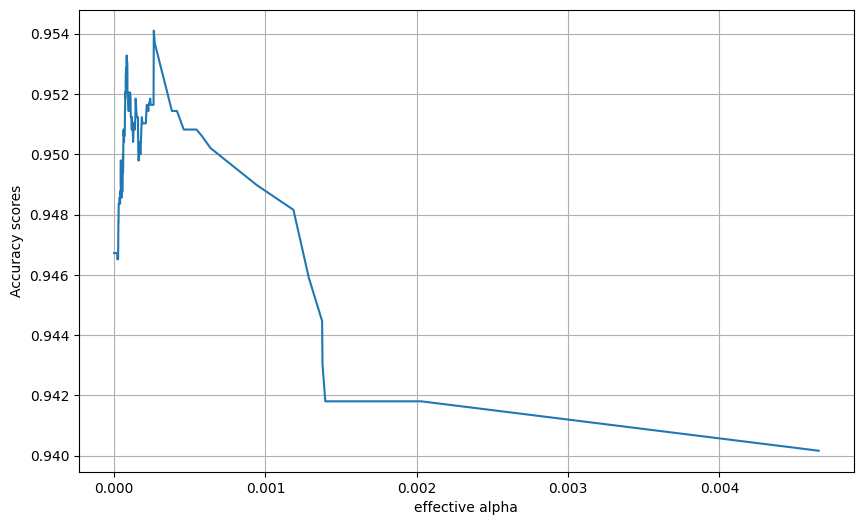

Decision Tree Accuracy (with pruning): 0.8776639344262295
Decision Tree Classification Report (with pruning):
               precision    recall  f1-score   support

           0       0.99      0.91      0.95      4563
           1       0.11      0.41      0.18        49
           2       0.19      0.29      0.23        93
           3       0.16      0.60      0.25        57
           4       0.23      0.31      0.26       118

    accuracy                           0.88      4880
   macro avg       0.34      0.50      0.38      4880
weighted avg       0.94      0.88      0.90      4880


Pruned Decision Tree Feature Importance:
                Feature  Importance
4                macula    0.245320
0           patient_age    0.226681
26         diabetes_yes    0.207656
14              drusens    0.077654
9         macular_edema    0.068324
3               vessels    0.048848
25          diabetes_no    0.020804
21  camera_NIKON NF5050    0.017915
1           patient_sex    0.01359

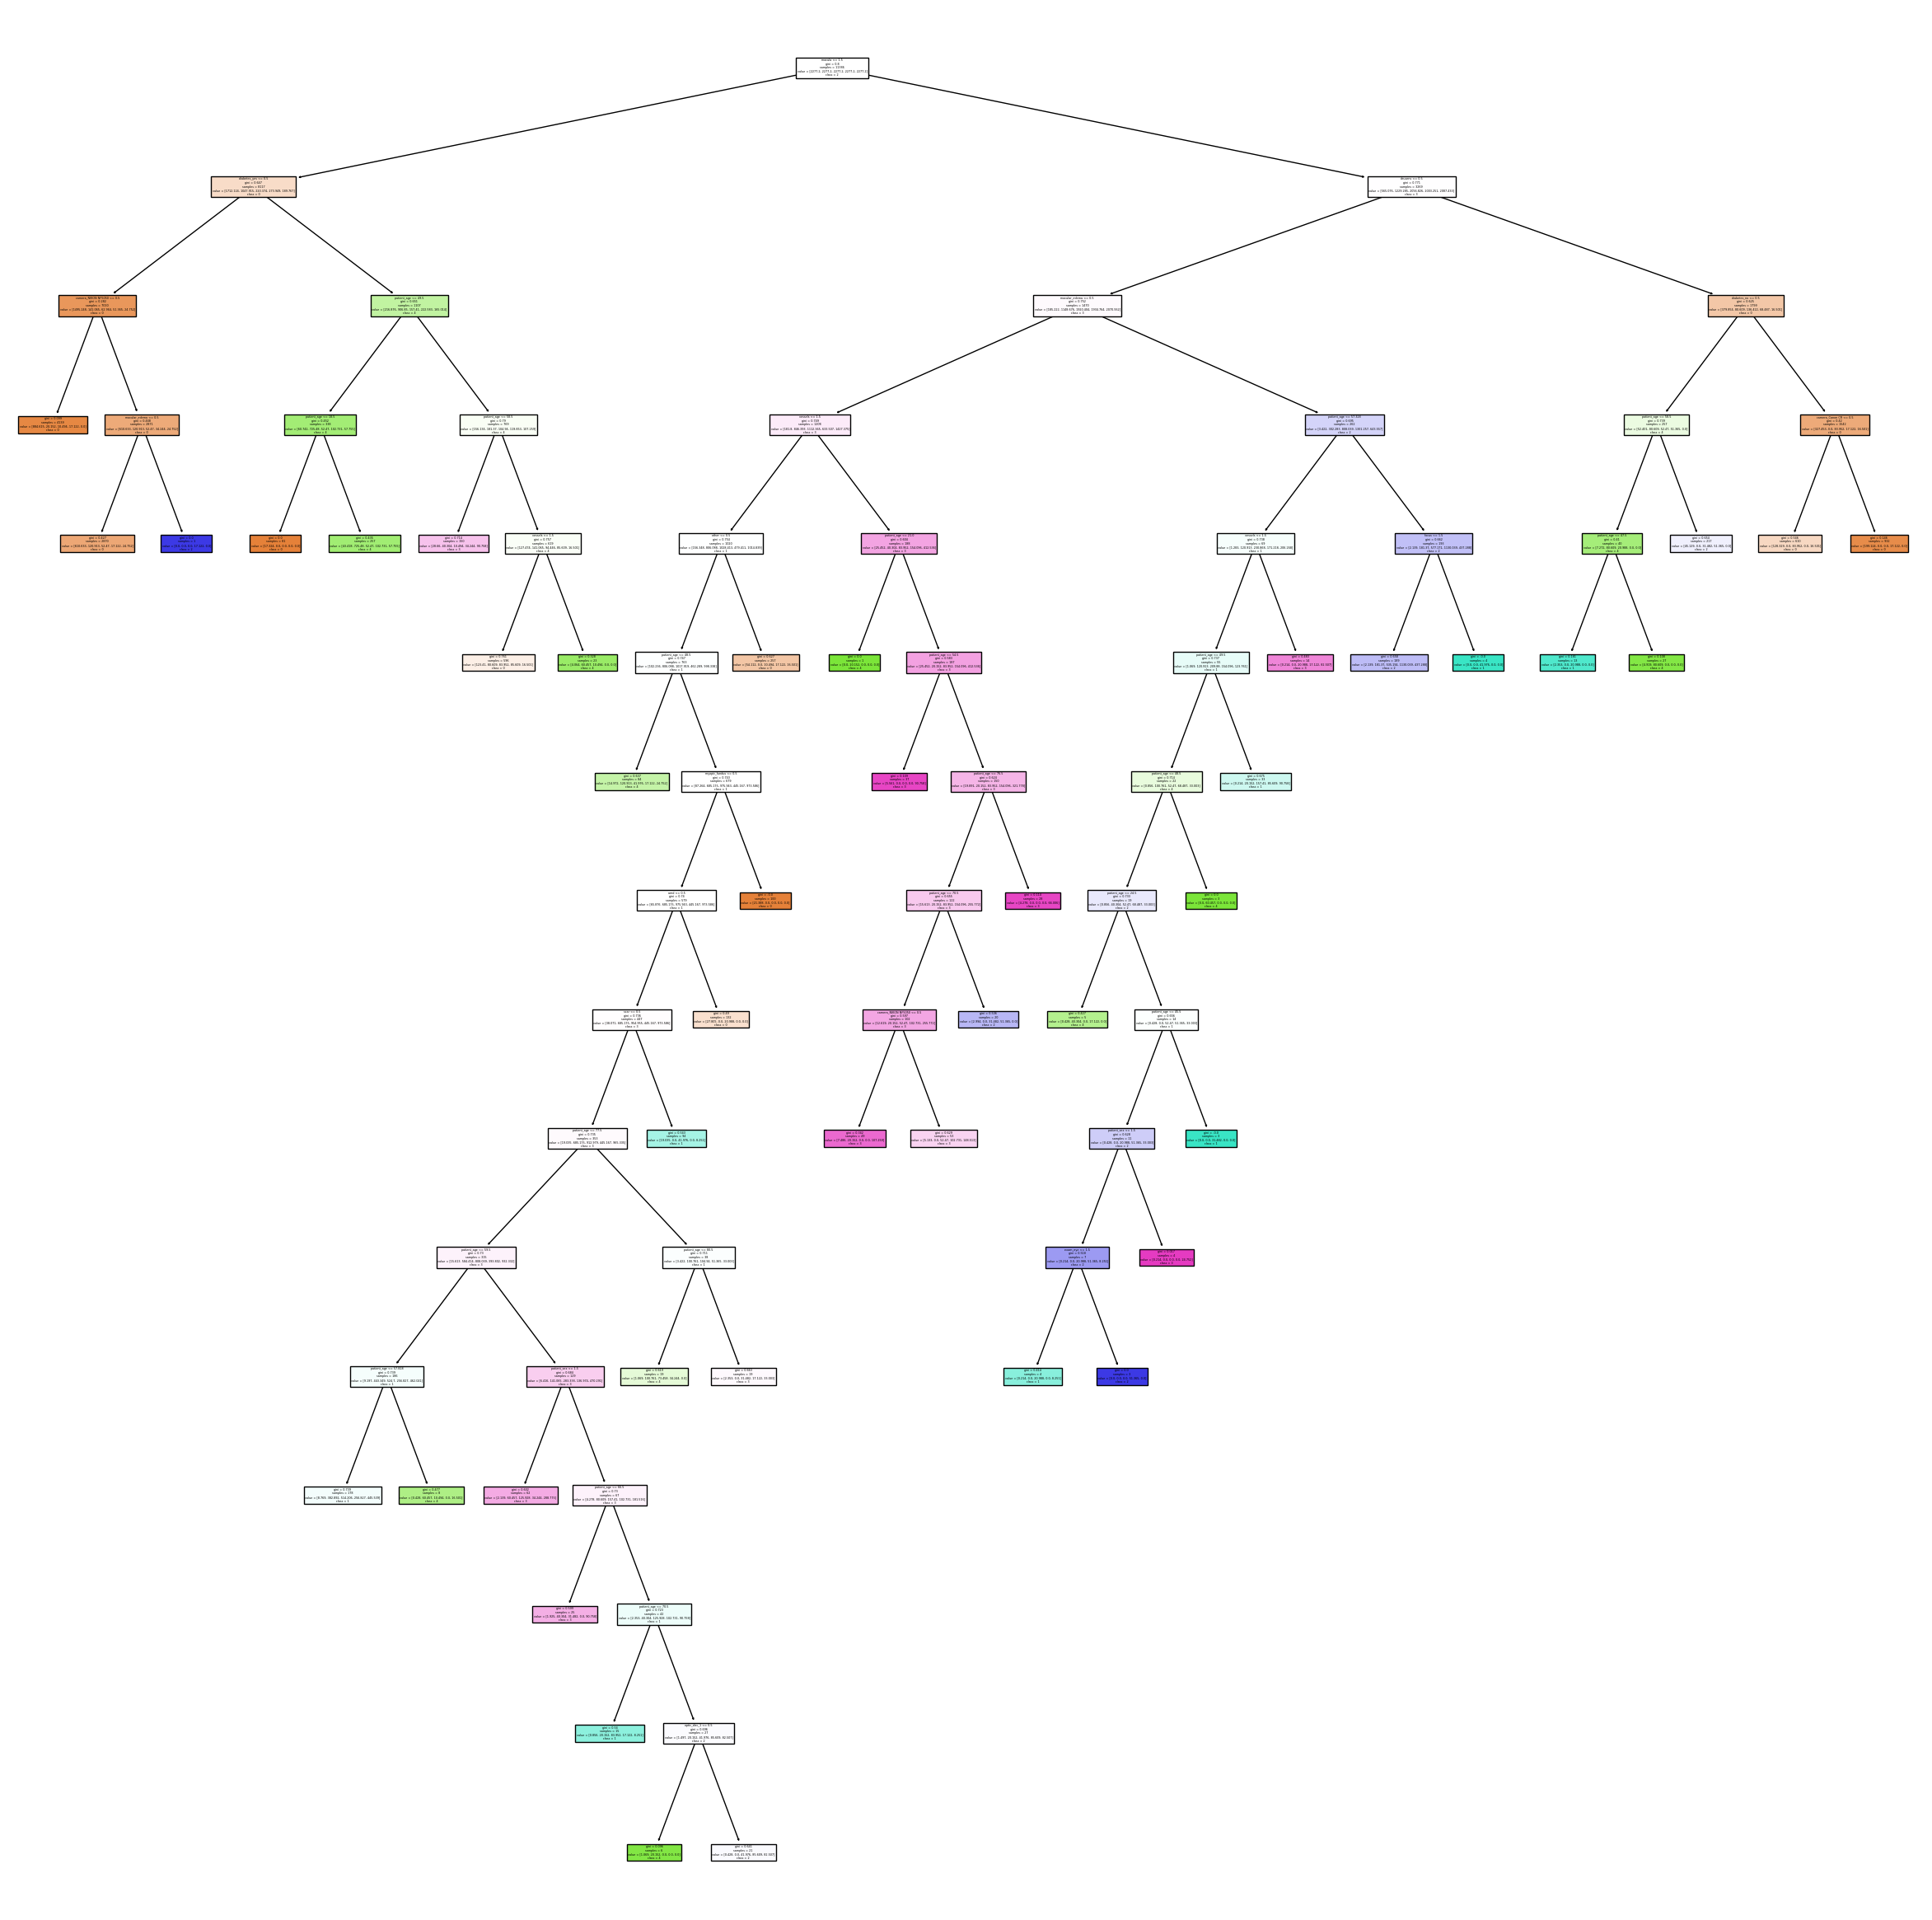

In [17]:
# Example usage
target_variable = 'DR_ICDR'
features = ['patient_age', 'patient_sex', 'exam_eye', 'vessels', 'macula',
            'focus', 'iluminaton', 'image_field', 'artifacts', 'macular_edema',
            'scar', 'nevus', 'amd', 'vascular_occlusion', 'drusens',
            'hemorrhage', 'retinal_detachment', 'myopic_fundus',
            'increased_cup_disc', 'other', 'camera_Canon CR',
            'camera_NIKON NF5050', 'optic_disc_1', 'optic_disc_2',
            'optic_disc_bv', 'diabetes_no', 'diabetes_yes']

# If plot tree = True will plot the original tree
analyze_image_quality(df, target_variable, features, plot_tree=False, prune=True, verbose=False)

### Diabetic Retinopathy 3 Class

In [18]:
df['DR_ICDR'] = df['DR_ICDR'].apply((lambda x: 1 if x in (1, 2, 3) else (2 if x == 4 else 0)))

########################################  Logistic Regression  ########################################
Logistic Regression Accuracy: 0.8932377049180328
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.92      0.95      4563
           1       0.24      0.48      0.32       199
           2       0.29      0.65      0.40       118

    accuracy                           0.89      4880
   macro avg       0.51      0.68      0.56      4880
weighted avg       0.94      0.89      0.91      4880


Logistic Regression Feature Importance:
                Feature  Importance
14              drusens    2.650000
25          diabetes_no    1.608932
20      camera_Canon CR    1.075120
19                other    0.630272
7           image_field    0.597164
12                  amd    0.578817
6            iluminaton    0.530138
17        myopic_fundus    0.513307
10                 scar    0.504364
8             artifac

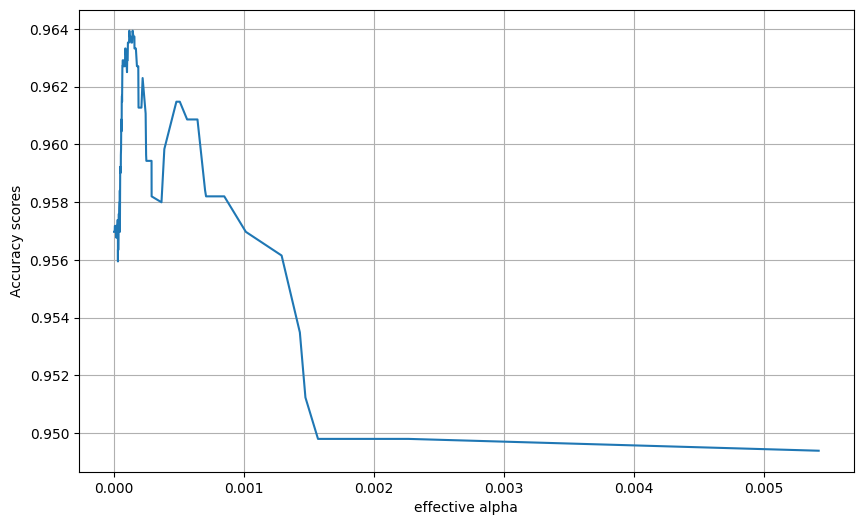

Decision Tree Accuracy (with pruning): 0.9247950819672132
Decision Tree Classification Report (with pruning):
               precision    recall  f1-score   support

           0       0.99      0.96      0.97      4563
           1       0.35      0.26      0.30       199
           2       0.28      0.76      0.41       118

    accuracy                           0.92      4880
   macro avg       0.54      0.66      0.56      4880
weighted avg       0.95      0.92      0.93      4880


Pruned Decision Tree Feature Importance:
                Feature  Importance
4                macula    0.373579
25          diabetes_no    0.160216
14              drusens    0.156582
0           patient_age    0.130037
3               vessels    0.035181
9         macular_edema    0.029987
19                other    0.018171
17        myopic_fundus    0.015695
12                  amd    0.014102
10                 scar    0.011330
13   vascular_occlusion    0.008000
21  camera_NIKON NF5050    0.00796

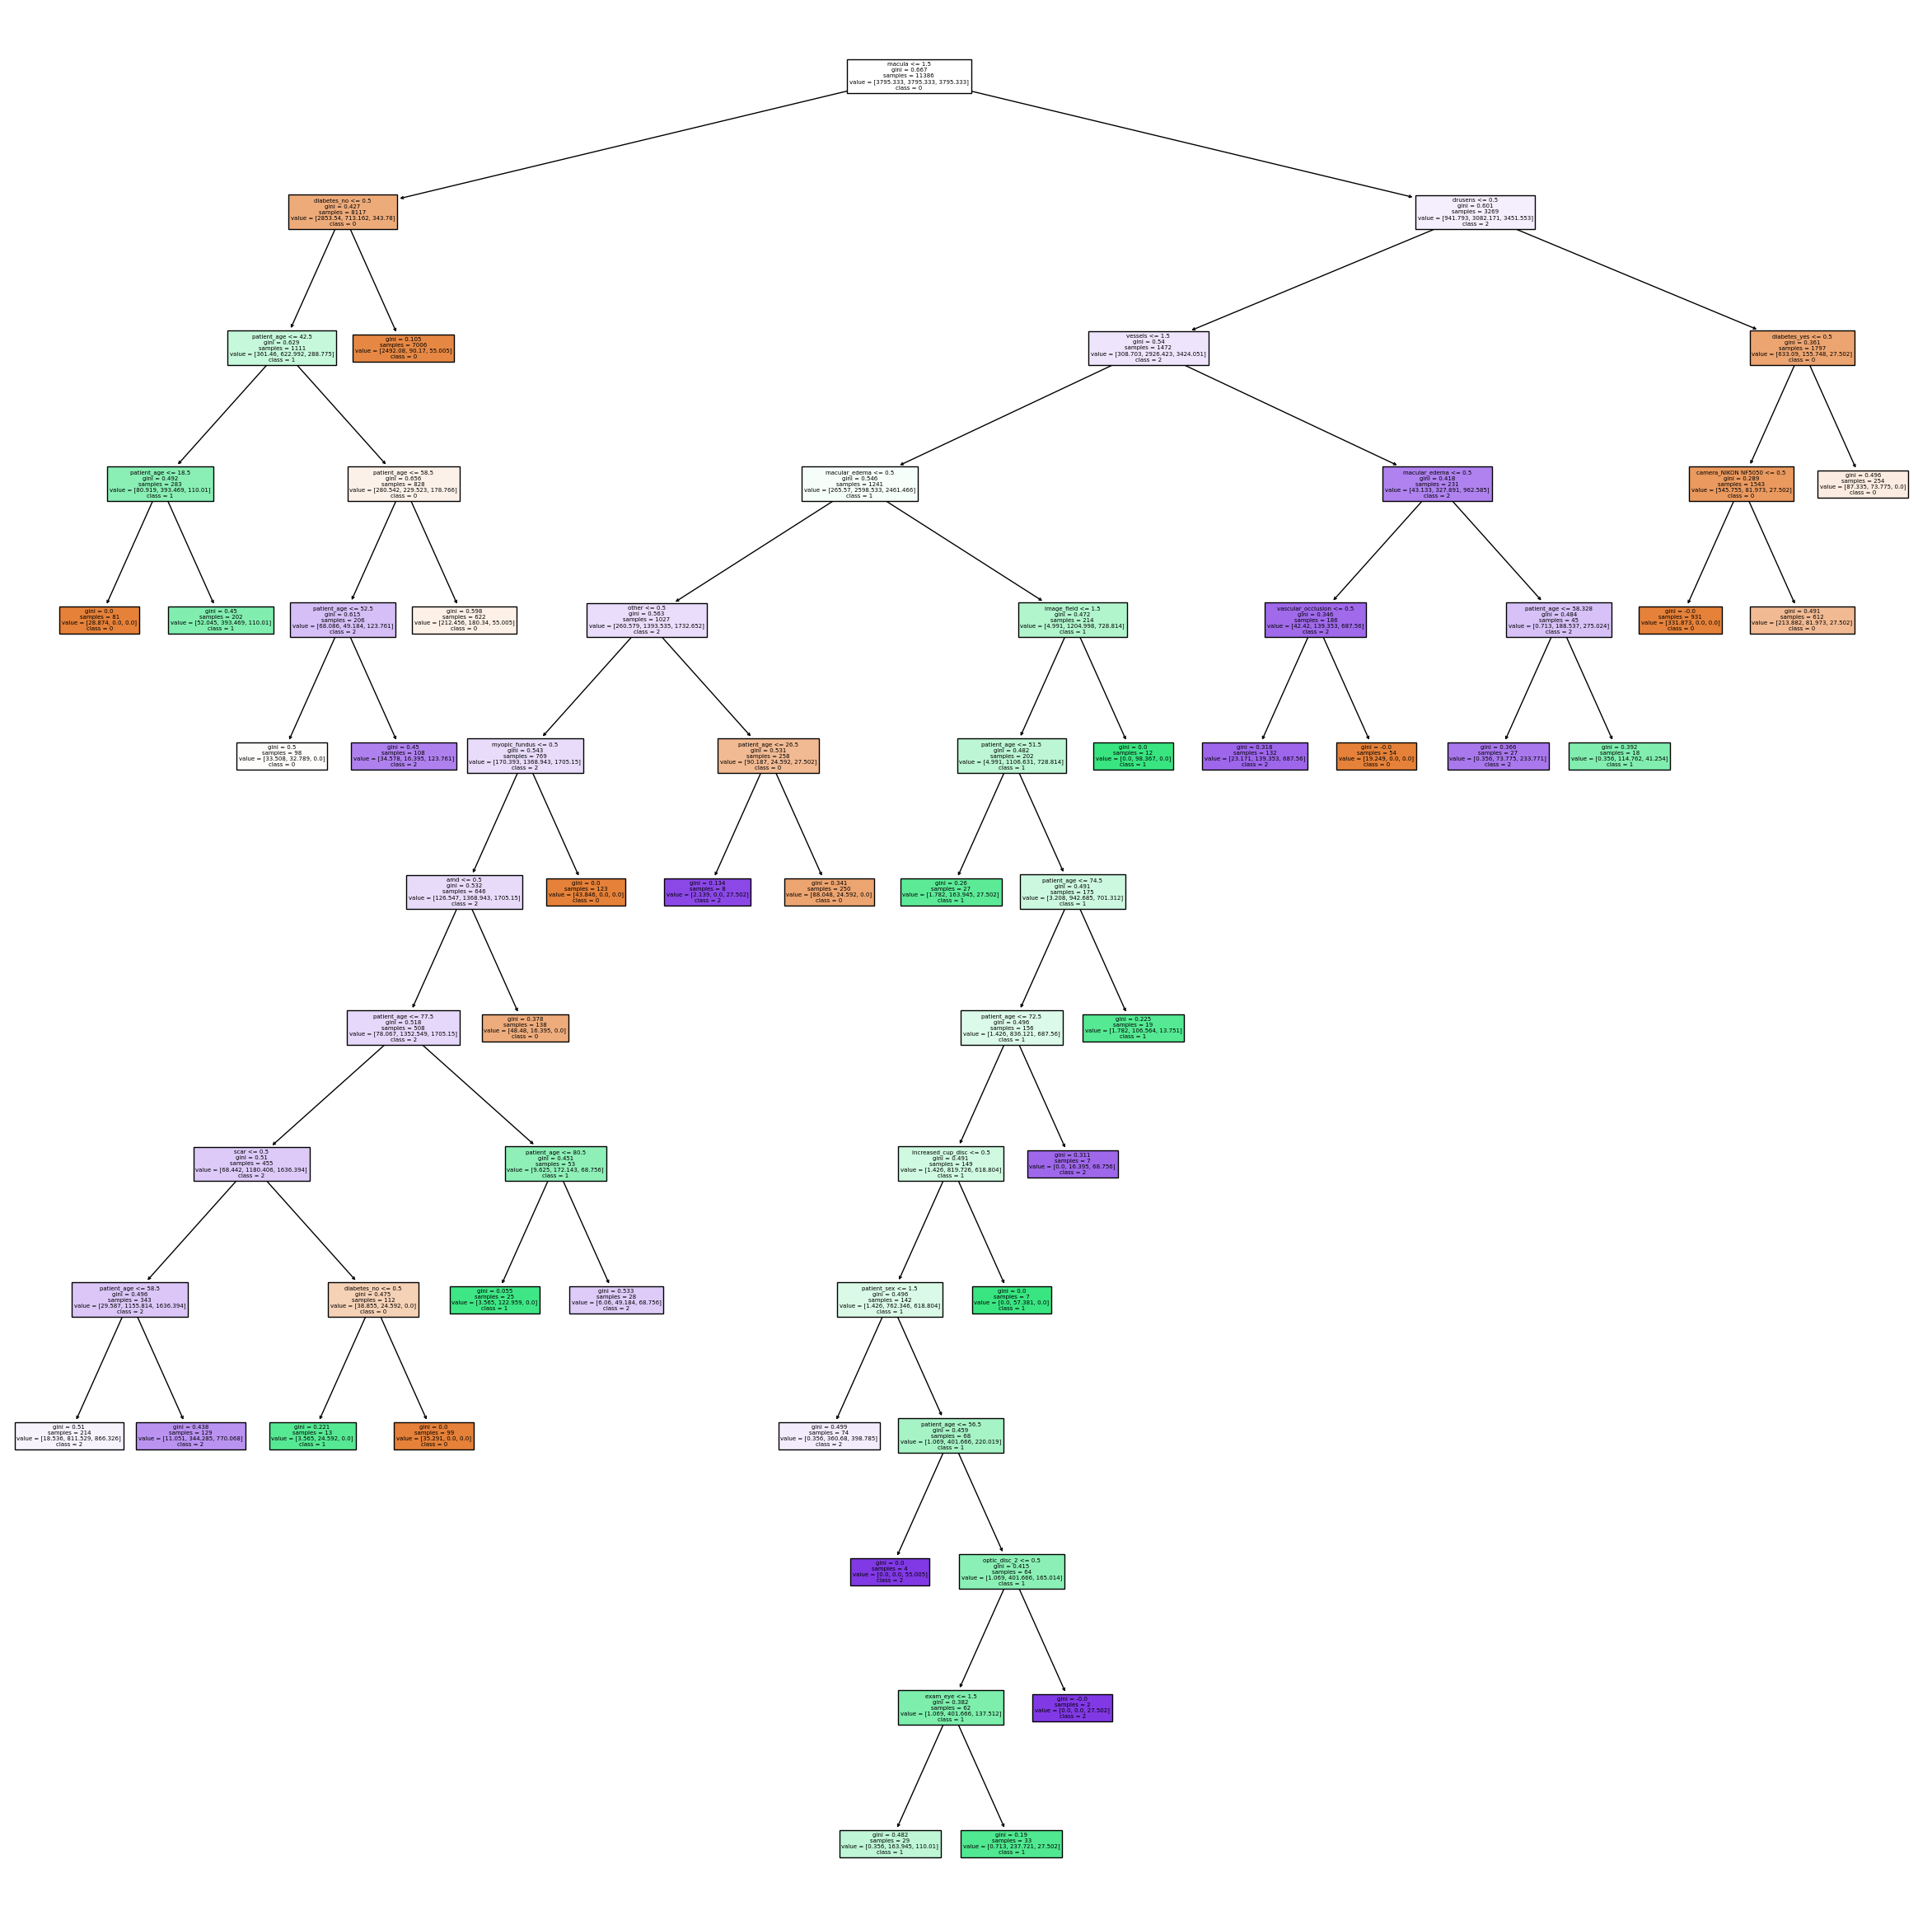

In [19]:
# Example usage
target_variable = 'DR_ICDR'
features = ['patient_age', 'patient_sex', 'exam_eye', 'vessels', 'macula',
            'focus', 'iluminaton', 'image_field', 'artifacts', 'macular_edema',
            'scar', 'nevus', 'amd', 'vascular_occlusion', 'drusens',
            'hemorrhage', 'retinal_detachment', 'myopic_fundus',
            'increased_cup_disc', 'other', 'camera_Canon CR',
            'camera_NIKON NF5050', 'optic_disc_1', 'optic_disc_2',
            'optic_disc_bv', 'diabetes_no', 'diabetes_yes']

analyze_image_quality(df, target_variable, features, plot_tree=False, prune=True, verbose=False)

### Diabetic Retinopathy 2 Class

########################################  Logistic Regression  ########################################
Logistic Regression Accuracy: 0.940983606557377
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.94      0.97      4566
           1       0.52      0.90      0.66       314

    accuracy                           0.94      4880
   macro avg       0.76      0.92      0.82      4880
weighted avg       0.96      0.94      0.95      4880


Logistic Regression Feature Importance:
                Feature  Importance
4                macula    4.814554
9         macular_edema    2.589045
3               vessels    1.433758
26         diabetes_yes    1.431695
21  camera_NIKON NF5050    0.299609
18   increased_cup_disc    0.150920
5                 focus    0.031636
24        optic_disc_bv   -0.016195
0           patient_age   -0.019956
2              exam_eye   -0.104192
16   retinal_detachment   -0.258799
22  

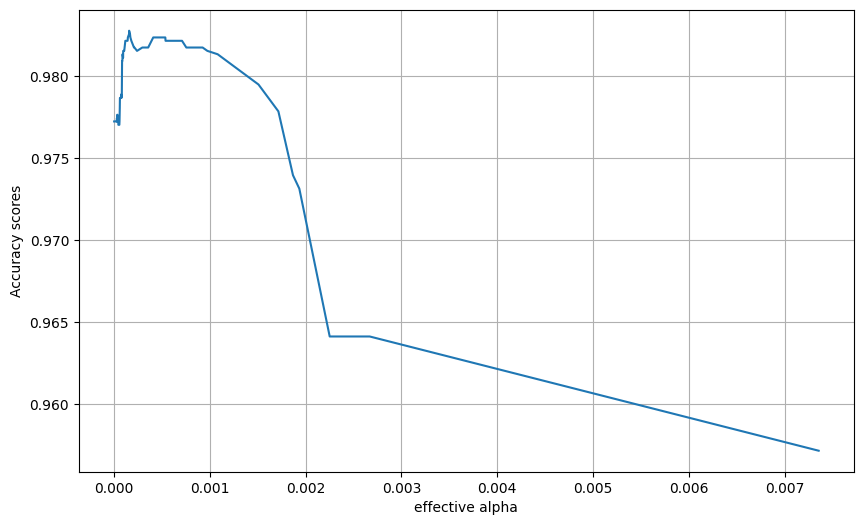

Decision Tree Accuracy (with pruning): 0.9625
Decision Tree Classification Report (with pruning):
               precision    recall  f1-score   support

           0       0.99      0.97      0.98      4566
           1       0.66      0.87      0.75       314

    accuracy                           0.96      4880
   macro avg       0.82      0.92      0.86      4880
weighted avg       0.97      0.96      0.96      4880


Pruned Decision Tree Feature Importance:
                Feature  Importance
4                macula    0.432895
14              drusens    0.246891
26         diabetes_yes    0.145636
19                other    0.039636
12                  amd    0.031909
0           patient_age    0.028980
17        myopic_fundus    0.027439
10                 scar    0.015686
13   vascular_occlusion    0.014400
3               vessels    0.008721
21  camera_NIKON NF5050    0.007808
18   increased_cup_disc    0.000000
25          diabetes_no    0.000000
24        optic_disc_bv    0

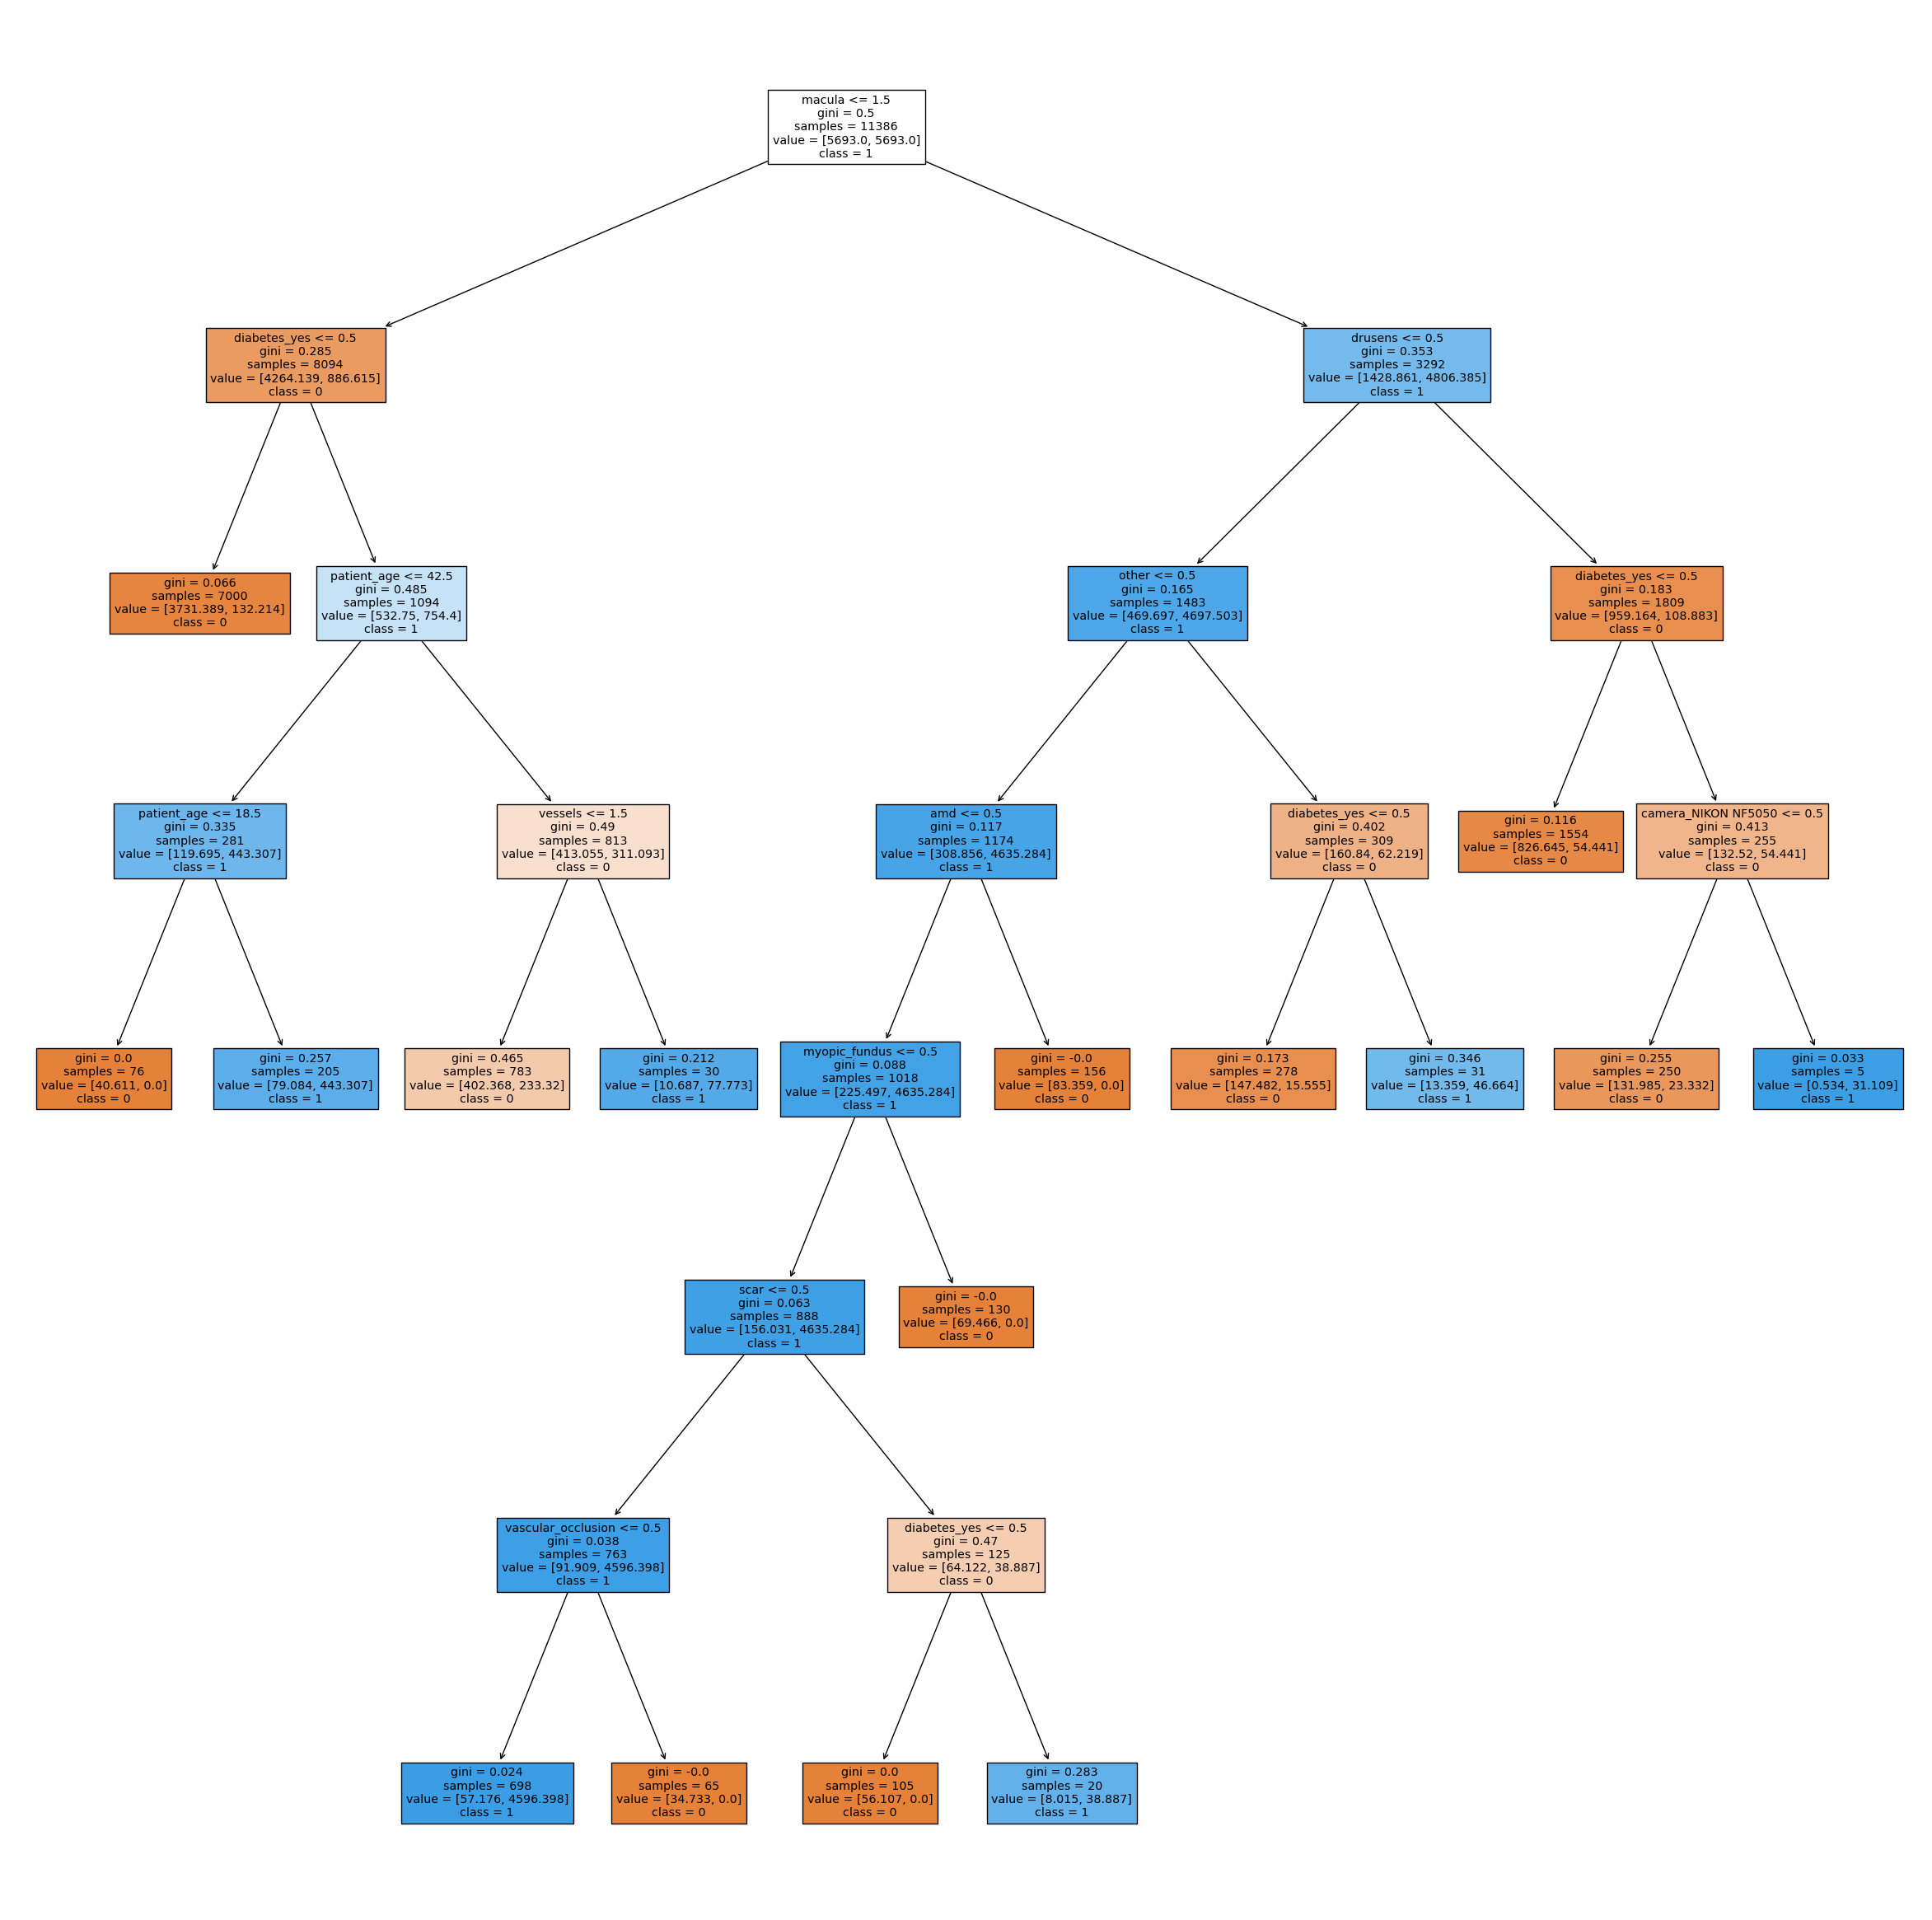

In [20]:
# Example usage
target_variable = 'diabetic_retinopathy'
features = ['patient_age', 'patient_sex', 'exam_eye', 'vessels', 'macula',
            'focus', 'iluminaton', 'image_field', 'artifacts', 'macular_edema',
            'scar', 'nevus', 'amd', 'vascular_occlusion', 'drusens',
            'hemorrhage', 'retinal_detachment', 'myopic_fundus',
            'increased_cup_disc', 'other', 'camera_Canon CR',
            'camera_NIKON NF5050', 'optic_disc_1', 'optic_disc_2',
            'optic_disc_bv', 'diabetes_no', 'diabetes_yes']

# If plot tree = True will plot the original tree
analyze_image_quality(df, target_variable, features, plot_tree=False, prune=True, verbose=False)